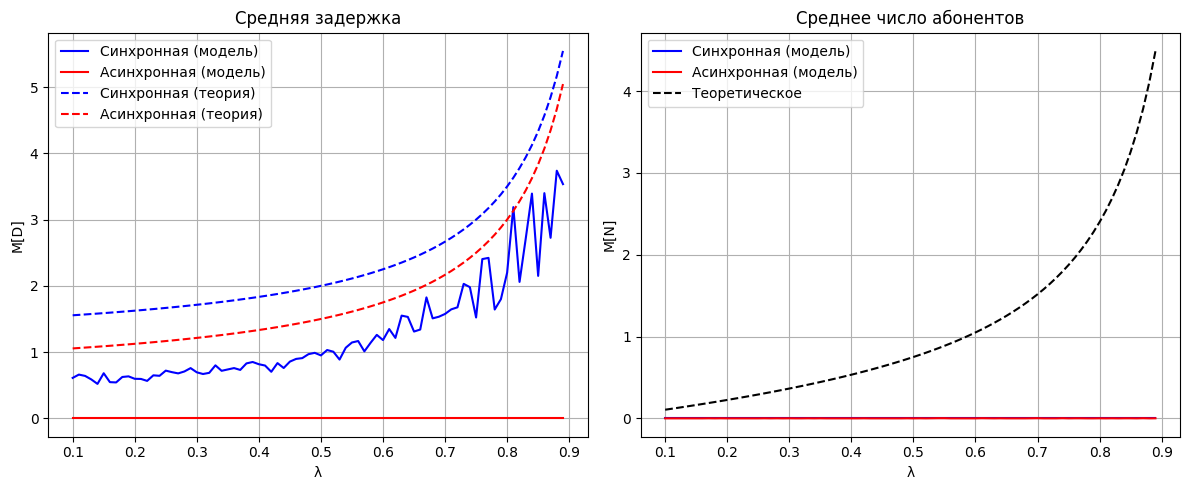


Численные результаты:

λ	M[D]_sync	M[D]_async	M[N]_sync	M[N]_async	Теор.M[D]_sync	Теор.M[D]_async	Теор.M[N]
0.1	0.610	0.000	0.000	0.000	1.556	1.056	0.106
0.1	0.660	0.000	0.000	0.000	1.562	1.062	0.117
0.1	0.641	0.000	0.000	0.000	1.568	1.068	0.128
0.1	0.588	0.000	0.000	0.000	1.575	1.075	0.140
0.1	0.520	0.000	0.000	0.000	1.581	1.081	0.151
0.1	0.681	0.000	0.000	0.000	1.588	1.088	0.163
0.2	0.546	0.000	0.000	0.000	1.595	1.095	0.175
0.2	0.542	0.000	0.000	0.001	1.602	1.102	0.187
0.2	0.624	0.000	0.000	0.000	1.610	1.110	0.200
0.2	0.634	0.000	0.000	0.001	1.617	1.117	0.212
0.2	0.597	0.000	0.000	0.000	1.625	1.125	0.225
0.2	0.595	0.000	0.000	0.000	1.633	1.133	0.238
0.2	0.565	0.000	0.000	0.000	1.641	1.141	0.251
0.2	0.649	0.000	0.000	0.000	1.649	1.149	0.264
0.2	0.642	0.000	0.000	0.000	1.658	1.158	0.278
0.2	0.720	0.000	0.000	0.000	1.667	1.167	0.292
0.3	0.697	0.000	0.000	0.001	1.676	1.176	0.306
0.3	0.679	0.000	0.000	0.000	1.685	1.185	0.320
0.3	0.708	0.000	0.000	0.001	1.694	1.194	0.334
0.3	0.758	0.000	0

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, is_synchronous: bool, mu: float = 1.0):
        self.is_synchronous = is_synchronous
        self.mu = mu  # время обслуживания (μ = 1)
        self.current_time = 0.0
        self.queue: List[Request] = []
        self.completed_requests: List[Request] = []
        self.is_server_busy = False
        self.next_service_time = 0.0
    
    def process_arrival(self, arrival_time: float):
        request = Request(arrival_time=arrival_time)
        if self.is_synchronous:
            # Для синхронной системы ждем следующего окна
            service_start = self.next_service_time
            while service_start < arrival_time:
                service_start += self.mu
            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.next_service_time = request.service_end_time
        else:
            # Для асинхронной системы начинаем обслуживание сразу если сервер свободен
            if not self.is_server_busy:
                request.service_start_time = arrival_time
                request.service_end_time = arrival_time + self.mu
                self.is_server_busy = True
            else:
                # Если сервер занят, ставим в очередь
                self.queue.append(request)
        
        self.completed_requests.append(request)
    
    def process_departure(self, current_time: float):
        if not self.is_synchronous and self.queue and not self.is_server_busy:
            next_request = self.queue.pop(0)
            next_request.service_start_time = current_time
            next_request.service_end_time = current_time + self.mu
            self.is_server_busy = True

    def update_server_state(self, current_time: float):
        if not self.is_synchronous:
            # Проверяем завершение обслуживания для асинхронной системы
            for request in self.completed_requests:
                if request.service_end_time and request.service_end_time <= current_time:
                    self.is_server_busy = False

def simulate(lambda_val: float, simulation_time: float, is_synchronous: bool) -> Tuple[float, float]:
    """
    Моделирование СМО
    Returns: (M[D], M[N])
    """
    system = QueueingSystem(is_synchronous=is_synchronous)
    
    # Генерируем пуассоновский поток заявок
    arrivals = []
    current_time = 0
    while current_time < simulation_time:
        current_time += np.random.exponential(1/lambda_val)
        arrivals.append(current_time)
    
    # Обрабатываем события
    for arrival_time in arrivals:
        system.update_server_state(arrival_time)
        system.process_arrival(arrival_time)
        system.process_departure(arrival_time)
    
    # Вычисляем характеристики
    delays = []
    queue_lengths = []
    
    for request in system.completed_requests:
        if request.service_start_time and request.arrival_time:
            delay = request.service_start_time - request.arrival_time
            delays.append(delay)
    
    MD = np.mean(delays) if delays else 0
    MN = len(system.queue) / simulation_time
    
    return MD, MN

def theoretical_values(lambda_val: float) -> Tuple[float, float]:
    """
    Вычисление теоретических значений M[D] и M[N]
    """
    N_lambda = lambda_val * (2 - lambda_val) / (2 * (1 - lambda_val))
    
    # Для асинхронной системы
    d_async = N_lambda / lambda_val
    
    # Для синхронной системы
    d_sync = N_lambda / lambda_val + 0.5
    
    return d_sync, d_async, N_lambda

def main():
    # Параметры моделирования
    simulation_time = 1000
    lambda_values = np.arange(0.1, 0.9, 0.01)
    
    # Массивы для хранения результатов
    sync_md = []
    async_md = []
    sync_mn = []
    async_mn = []
    theoretical_sync = []
    theoretical_async = []
    theoretical_n = []
    
    # Проводим моделирование для разных значений λ
    for lambda_val in lambda_values:
        # Синхронная система
        md_sync, mn_sync = simulate(lambda_val, simulation_time, True)
        sync_md.append(md_sync)
        sync_mn.append(mn_sync)
        
        # Асинхронная система
        md_async, mn_async = simulate(lambda_val, simulation_time, False)
        async_md.append(md_async)
        async_mn.append(mn_async)
        
        # Теоретические значения
        d_sync, d_async, n = theoretical_values(lambda_val)
        theoretical_sync.append(d_sync)
        theoretical_async.append(d_async)
        theoretical_n.append(n)
    
    # Построение графиков
    plt.figure(figsize=(12, 5))
    
    # График M[D]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_values, sync_md, 'b-', label='Синхронная (модель)')
    plt.plot(lambda_values, async_md, 'r-', label='Асинхронная (модель)')
    plt.plot(lambda_values, theoretical_sync, 'b--', label='Синхронная (теория)')
    plt.plot(lambda_values, theoretical_async, 'r--', label='Асинхронная (теория)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Средняя задержка')
    plt.legend()
    plt.grid(True)
    
    # График M[N]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_values, sync_mn, 'b-', label='Синхронная (модель)')
    plt.plot(lambda_values, async_mn, 'r-', label='Асинхронная (модель)')
    plt.plot(lambda_values, theoretical_n, 'k--', label='Теоретическое')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Среднее число абонентов')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Вывод численных результатов
    print("\nЧисленные результаты:")
    print("\nλ\tM[D]_sync\tM[D]_async\tM[N]_sync\tM[N]_async\tТеор.M[D]_sync\tТеор.M[D]_async\tТеор.M[N]")
    for i, lambda_val in enumerate(lambda_values):
        print(f"{lambda_val:.1f}\t{sync_md[i]:.3f}\t{async_md[i]:.3f}\t{sync_mn[i]:.3f}\t{async_mn[i]:.3f}\t{theoretical_sync[i]:.3f}\t{theoretical_async[i]:.3f}\t{theoretical_n[i]:.3f}")

if __name__ == "__main__":
    main()

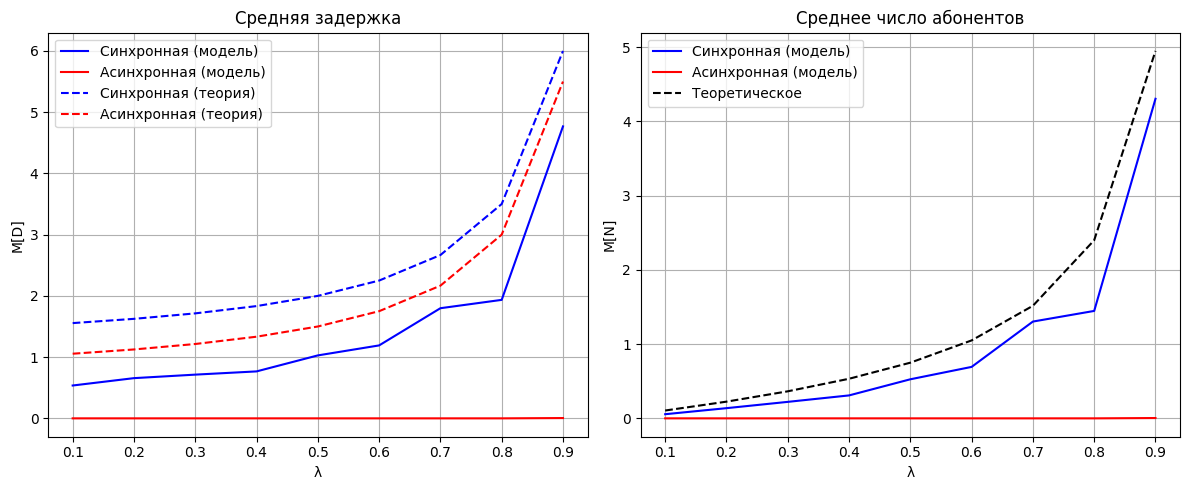


Численные результаты:

λ	M[D]_sync	M[D]_async	M[N]_sync	M[N]_async	Теор.M[D]_sync	Теор.M[D]_async	Теор.M[N]
0.1	0.536	0.000	0.056	0.000	1.556	1.056	0.106
0.2	0.657	0.000	0.137	0.000	1.625	1.125	0.225
0.3	0.714	0.000	0.222	0.000	1.714	1.214	0.364
0.4	0.767	0.000	0.309	0.000	1.833	1.333	0.533
0.5	1.028	0.000	0.526	0.000	2.000	1.500	0.750
0.6	1.191	0.000	0.693	0.000	2.250	1.750	1.050
0.7	1.799	0.000	1.304	0.000	2.667	2.167	1.517
0.8	1.935	0.000	1.447	0.000	3.500	3.000	2.400
0.9	4.768	0.005	4.305	0.004	6.000	5.500	4.950


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple


@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None


class QueueingSystem:

    def __init__(self, is_synchronous: bool, mu: float = 1.0):
        self.is_synchronous = is_synchronous
        self.mu = mu  # время обслуживания (μ = 1)
        self.current_time = 0.0
        self.queue: List[Request] = []
        self.completed_requests: List[Request] = []
        self.is_server_busy = False
        self.next_service_time = 0.0

    def process_arrival(self, arrival_time: float):
        request = Request(arrival_time=arrival_time)
        if self.is_synchronous:
            # Для синхронной системы ждем следующего окна
            service_start = self.next_service_time
            while service_start < arrival_time:
                service_start += self.mu
            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.next_service_time = request.service_end_time
        else:
            # Для асинхронной системы начинаем обслуживание сразу если сервер свободен
            if not self.is_server_busy:
                request.service_start_time = arrival_time
                request.service_end_time = arrival_time + self.mu
                self.is_server_busy = True
            else:
                # Если сервер занят, ставим в очередь
                self.queue.append(request)

        self.completed_requests.append(request)

    def process_departure(self, current_time: float):
        if not self.is_synchronous and self.queue and not self.is_server_busy:
            next_request = self.queue.pop(0)
            next_request.service_start_time = current_time
            next_request.service_end_time = current_time + self.mu
            self.is_server_busy = True

    def update_server_state(self, current_time: float):
        if not self.is_synchronous:
            # Проверяем завершение обслуживания для асинхронной системы
            for request in self.completed_requests:
                if request.service_end_time and request.service_end_time <= current_time:
                    self.is_server_busy = False
                    # Обрабатываем следующую заявку в очереди
                    if self.queue:
                        next_request = self.queue[0]
                        next_request.service_start_time = current_time
                        next_request.service_end_time = current_time + self.mu
                        self.is_server_busy = True
                        self.queue.pop(0)


def simulate(lambda_val: float, simulation_time: float,
             is_synchronous: bool) -> Tuple[float, float]:
    """
    Моделирование СМО
    Returns: (M[D], M[N])
    """
    system = QueueingSystem(is_synchronous=is_synchronous)

    # Генерируем пуассоновский поток заявок
    arrivals = []
    current_time = 0
    while current_time < simulation_time:
        current_time += np.random.exponential(1 / lambda_val)
        arrivals.append(current_time)

    # Обрабатываем события
    for arrival_time in arrivals:
        system.update_server_state(arrival_time)
        system.process_arrival(arrival_time)
        system.process_departure(arrival_time)

    # Вычисляем характеристики
    delays = []
    queue_lengths = []

    for request in system.completed_requests:
        if request.service_start_time and request.arrival_time:
            delay = request.service_start_time - request.arrival_time
            delays.append(delay)

    MD = np.mean(delays) if delays else 0
    # Вычисляем среднее число абонентов по Little's Law
    lambda_actual = len(arrivals) / simulation_time
    MN = lambda_actual * MD

    return MD, MN


def theoretical_values(lambda_val: float) -> Tuple[float, float]:
    """
    Вычисление теоретических значений M[D] и M[N]
    """
    N_lambda = lambda_val * (2 - lambda_val) / (2 * (1 - lambda_val))

    # Для асинхронной системы
    d_async = N_lambda / lambda_val

    # Для синхронной системы
    d_sync = N_lambda / lambda_val + 0.5

    return d_sync, d_async, N_lambda


def main():
    # Параметры моделирования
    simulation_time = 1000
    lambda_values = np.arange(0.1, 1.0, 0.1)

    # Массивы для хранения результатов
    sync_md = []
    async_md = []
    sync_mn = []
    async_mn = []
    theoretical_sync = []
    theoretical_async = []
    theoretical_n = []

    # Проводим моделирование для разных значений λ
    for lambda_val in lambda_values:
        # Синхронная система
        md_sync, mn_sync = simulate(lambda_val, simulation_time, True)
        sync_md.append(md_sync)
        sync_mn.append(mn_sync)

        # Асинхронная система
        md_async, mn_async = simulate(lambda_val, simulation_time, False)
        async_md.append(md_async)
        async_mn.append(mn_async)

        # Теоретические значения
        d_sync, d_async, n = theoretical_values(lambda_val)
        theoretical_sync.append(d_sync)
        theoretical_async.append(d_async)
        theoretical_n.append(n)

    # Построение графиков
    plt.figure(figsize=(12, 5))

    # График M[D]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_values, sync_md, 'b-', label='Синхронная (модель)')
    plt.plot(lambda_values, async_md, 'r-', label='Асинхронная (модель)')
    plt.plot(lambda_values,
             theoretical_sync,
             'b--',
             label='Синхронная (теория)')
    plt.plot(lambda_values,
             theoretical_async,
             'r--',
             label='Асинхронная (теория)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Средняя задержка')
    plt.legend()
    plt.grid(True)

    # График M[N]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_values, sync_mn, 'b-', label='Синхронная (модель)')
    plt.plot(lambda_values, async_mn, 'r-', label='Асинхронная (модель)')
    plt.plot(lambda_values, theoretical_n, 'k--', label='Теоретическое')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Среднее число абонентов')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Вывод численных результатов
    print("\nЧисленные результаты:")
    print(
        "\nλ\tM[D]_sync\tM[D]_async\tM[N]_sync\tM[N]_async\tТеор.M[D]_sync\tТеор.M[D]_async\tТеор.M[N]"
    )
    for i, lambda_val in enumerate(lambda_values):
        print(
            f"{lambda_val:.1f}\t{sync_md[i]:.3f}\t{async_md[i]:.3f}\t{sync_mn[i]:.3f}\t{async_mn[i]:.3f}\t{theoretical_sync[i]:.3f}\t{theoretical_async[i]:.3f}\t{theoretical_n[i]:.3f}"
        )


if __name__ == "__main__":
    main()

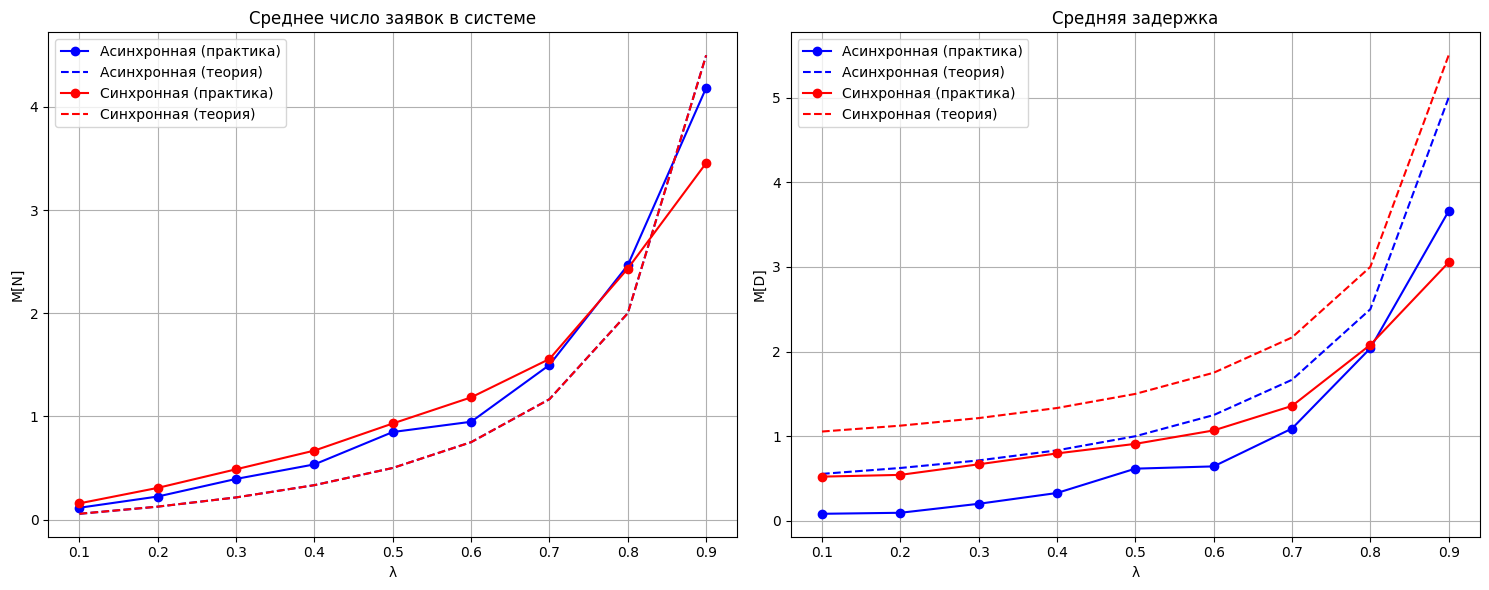

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param  # интенсивность входного потока
        self.mu = 1  # время обслуживания (μ = 1)
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, simulation_time: float) -> List[float]:
        """Генерация моментов прихода заявок (пуассоновский поток)"""
        times = []
        current_time = 0
        while current_time < simulation_time:
            # Интервал между приходами заявок распределен по экспоненциальному закону
            interval = np.random.exponential(1/self.lambda_param)
            current_time += interval
            if current_time < simulation_time:
                times.append(current_time)
        return times
    
    def simulate(self, simulation_time: float):
        """Моделирование работы СМО"""
        arrival_times = self.generate_arrival_times(simulation_time)
        
        for arrival_time in arrival_times:
            request = Request(arrival_time=arrival_time)
            
            if self.is_synchronous:
                # Для синхронной системы
                service_start = max(self.current_time, np.ceil(arrival_time))
            else:
                # Для асинхронной системы
                service_start = max(self.current_time, arrival_time)
                
            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.current_time = request.service_end_time
            self.completed_requests.append(request)
            
    def calculate_metrics(self) -> Tuple[float, float]:
        """Вычисление метрик M[D] и M[N]"""
        if not self.completed_requests:
            return 0, 0
            
        # Вычисление средней задержки (M[D])
        delays = [req.service_start_time - req.arrival_time 
                 for req in self.completed_requests]
        mean_delay = np.mean(delays)
        
        # Вычисление среднего числа заявок в системе (M[N])
        times = sorted([(req.arrival_time, 1) for req in self.completed_requests] +
                      [(req.service_end_time, -1) for req in self.completed_requests])
        
        current_requests = 0
        total_requests = 0
        last_time = times[0][0]
        
        for time, change in times:
            total_requests += current_requests * (time - last_time)
            current_requests += change
            last_time = time
            
        mean_requests = total_requests / times[-1][0]
        
        return mean_delay, mean_requests

def theoretical_values(lambda_param: float) -> Tuple[Tuple[float, float], Tuple[float, float]]:
    """Вычисление теоретических значений для обоих типов систем"""
    # Теоретические значения для асинхронной системы
    N_async = lambda_param / (2 * (1 - lambda_param))
    D_async = N_async / lambda_param
    
    # Теоретические значения для синхронной системы
    N_sync = lambda_param / (2 * (1 - lambda_param))
    D_sync = N_sync / lambda_param + 0.5
    
    return (D_async, N_async), (D_sync, N_sync)

def compare_systems(lambda_params: List[float], simulation_time: float = 1000):
    """Сравнение теоретических и практических результатов для разных λ"""
    results = {
        'async': {'D': [], 'N': [], 'D_theory': [], 'N_theory': []},
        'sync': {'D': [], 'N': [], 'D_theory': [], 'N_theory': []}
    }
    
    for lambda_param in lambda_params:
        # Моделирование асинхронной системы
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        async_system.simulate(simulation_time)
        D_async, N_async = async_system.calculate_metrics()
        
        # Моделирование синхронной системы
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        sync_system.simulate(simulation_time)
        D_sync, N_sync = sync_system.calculate_metrics()
        
        # Теоретические значения
        (D_async_theory, N_async_theory), (D_sync_theory, N_sync_theory) = \
            theoretical_values(lambda_param)
            
        # Сохранение результатов
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['async']['D_theory'].append(D_async_theory)
        results['async']['N_theory'].append(N_async_theory)
        
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['sync']['D_theory'].append(D_sync_theory)
        results['sync']['N_theory'].append(N_sync_theory)
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    """Построение графиков для сравнения результатов"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График для M[N]
    ax1.plot(lambda_params, results['async']['N'], 'bo-', label='Асинхронная (практика)')
    ax1.plot(lambda_params, results['async']['N_theory'], 'b--', label='Асинхронная (теория)')
    ax1.plot(lambda_params, results['sync']['N'], 'ro-', label='Синхронная (практика)')
    ax1.plot(lambda_params, results['sync']['N_theory'], 'r--', label='Синхронная (теория)')
    ax1.set_xlabel('λ')
    ax1.set_ylabel('M[N]')
    ax1.set_title('Среднее число заявок в системе')
    ax1.legend()
    ax1.grid(True)
    
    # График для M[D]
    ax2.plot(lambda_params, results['async']['D'], 'bo-', label='Асинхронная (практика)')
    ax2.plot(lambda_params, results['async']['D_theory'], 'b--', label='Асинхронная (теория)')
    ax2.plot(lambda_params, results['sync']['D'], 'ro-', label='Синхронная (практика)')
    ax2.plot(lambda_params, results['sync']['D_theory'], 'r--', label='Синхронная (теория)')
    ax2.set_xlabel('λ')
    ax2.set_ylabel('M[D]')
    ax2.set_title('Средняя задержка')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Пример использования
if __name__ == "__main__":
    # Значения λ для моделирования (от 0.1 до 0.9)
    lambda_params = np.linspace(0.1, 0.9, 9)
    
    # Проведение моделирования
    results = compare_systems(lambda_params)
    
    # Построение графиков
    plot_results(lambda_params, results)


Результаты моделирования:
λ	| M[N] теор	| M[N] async	| M[N] sync	| M[D] async теор	| M[D] async практ	| M[D] sync теор	| M[D] sync практ
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.102	| 0.163	| 1.056	| 0.044	| 1.556	| 0.497
0.2	| 0.225	| 0.245	| 0.314	| 1.125	| 0.173	| 1.625	| 0.645
0.3	| 0.364	| 0.401	| 0.498	| 1.214	| 0.301	| 1.714	| 0.777
0.4	| 0.533	| 0.624	| 0.712	| 1.333	| 0.440	| 1.833	| 0.877
0.5	| 0.750	| 0.808	| 1.039	| 1.500	| 0.590	| 2.000	| 1.026
0.6	| 1.050	| 1.113	| 1.428	| 1.750	| 0.854	| 2.250	| 1.421
0.7	| 1.517	| 1.246	| 1.802	| 2.167	| 0.904	| 2.667	| 1.514
0.8	| 2.400	| 1.915	| 2.354	| 3.000	| 1.458	| 3.500	| 2.085
0.9	| 4.950	| 4.658	| 4.613	| 5.500	| 4.094	| 6.000	| 4.156


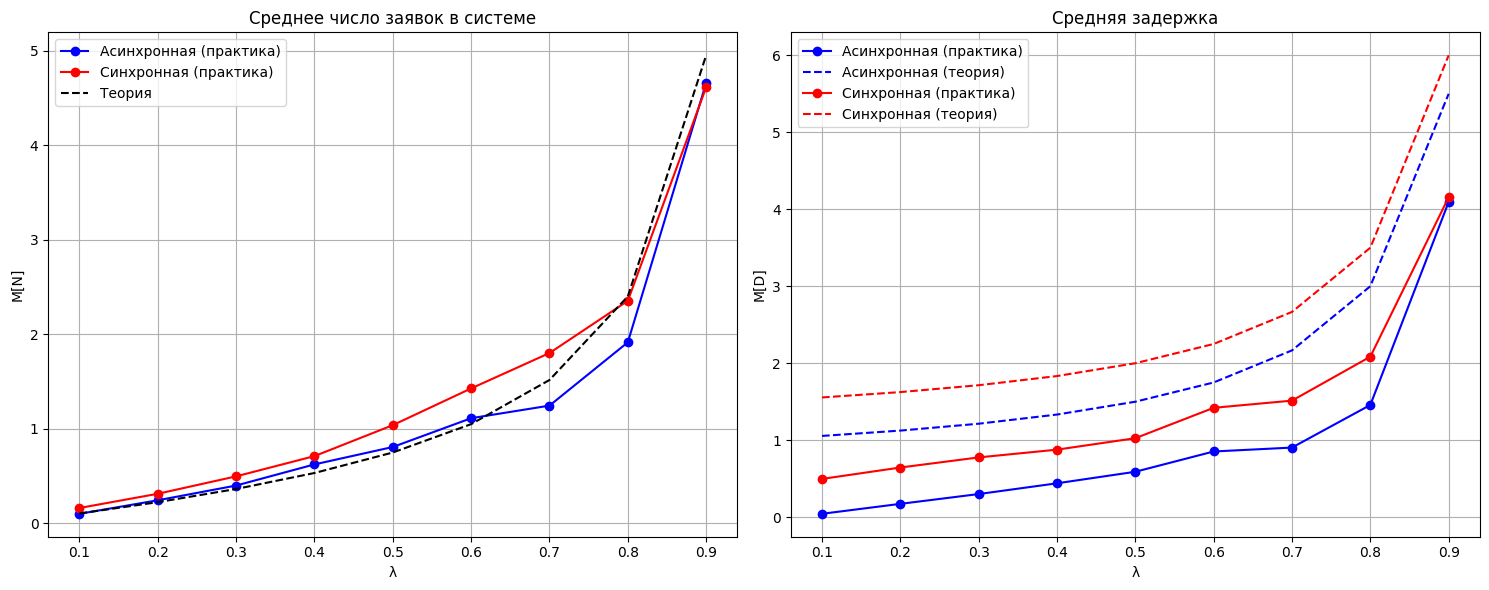

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param  # интенсивность входного потока
        self.mu = 1  # время обслуживания (μ = 1)
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, simulation_time: float) -> List[float]:
        """Генерация моментов прихода заявок (пуассоновский поток)"""
        times = []
        current_time = 0
        while current_time < simulation_time:
            # Интервал между приходами заявок распределен по экспоненциальному закону
            interval = np.random.exponential(1/self.lambda_param)
            current_time += interval
            if current_time < simulation_time:
                times.append(current_time)
        return times
    
    def simulate(self, simulation_time: float):
        """Моделирование работы СМО"""
        arrival_times = self.generate_arrival_times(simulation_time)
        
        for arrival_time in arrival_times:
            request = Request(arrival_time=arrival_time)
            
            if self.is_synchronous:
                # Для синхронной системы
                service_start = max(self.current_time, np.ceil(arrival_time))
            else:
                # Для асинхронной системы
                service_start = max(self.current_time, arrival_time)
                
            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.current_time = request.service_end_time
            self.completed_requests.append(request)
            
    def calculate_metrics(self) -> Tuple[float, float]:
        """Вычисление метрик M[D] и M[N]"""
        if not self.completed_requests:
            return 0, 0
            
        # Вычисление средней задержки (M[D])
        delays = [req.service_start_time - req.arrival_time 
                 for req in self.completed_requests]
        mean_delay = np.mean(delays)
        
        # Вычисление среднего числа заявок в системе (M[N])
        times = sorted([(req.arrival_time, 1) for req in self.completed_requests] +
                      [(req.service_end_time, -1) for req in self.completed_requests])
        
        current_requests = 0
        total_requests = 0
        last_time = times[0][0]
        
        for time, change in times:
            total_requests += current_requests * (time - last_time)
            current_requests += change
            last_time = time
            
        mean_requests = total_requests / times[-1][0]
        
        return mean_delay, mean_requests

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    """Вычисление теоретических значений
    Returns:
        N - теоретическое среднее число заявок (общее для обоих типов)
        D_async - теоретическая задержка для асинхронной системы
        D_sync - теоретическая задержка для синхронной системы
    """
    # Теоретическое среднее число заявок (одинаково для обоих типов)
    N = lambda_param * (2 - lambda_param) / (2 * (1 - lambda_param))
    
    # Теоретические значения задержки
    D_async = N / lambda_param
    D_sync = N / lambda_param + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], simulation_time: float = 1000):
    """Сравнение теоретических и практических результатов для разных λ"""
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nРезультаты моделирования:")
    print("λ\t| M[N] теор\t| M[N] async\t| M[N] sync\t| M[D] async теор\t| M[D] async практ\t| M[D] sync теор\t| M[D] sync практ")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        # Моделирование асинхронной системы
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        async_system.simulate(simulation_time)
        D_async, N_async = async_system.calculate_metrics()
        
        # Моделирование синхронной системы
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        sync_system.simulate(simulation_time)
        D_sync, N_sync = sync_system.calculate_metrics()
        
        # Теоретические значения
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        # Сохранение результатов
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        # Вывод результатов в консоль
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    """Построение графиков для сравнения результатов"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # График для M[N]
    ax1.plot(lambda_params, results['async']['N'], 'bo-', label='Асинхронная (практика)')
    ax1.plot(lambda_params, results['sync']['N'], 'ro-', label='Синхронная (практика)')
    ax1.plot(lambda_params, results['theory']['N'], 'k--', label='Теория')
    ax1.set_xlabel('λ')
    ax1.set_ylabel('M[N]')
    ax1.set_title('Среднее число заявок в системе')
    ax1.legend()
    ax1.grid(True)
    
    # График для M[D]
    ax2.plot(lambda_params, results['async']['D'], 'bo-', label='Асинхронная (практика)')
    ax2.plot(lambda_params, results['theory']['D_async'], 'b--', label='Асинхронная (теория)')
    ax2.plot(lambda_params, results['sync']['D'], 'ro-', label='Синхронная (практика)')
    ax2.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Синхронная (теория)')
    ax2.set_xlabel('λ')
    ax2.set_ylabel('M[D]')
    ax2.set_title('Средняя задержка')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Пример использования
if __name__ == "__main__":
    # Значения λ для моделирования (от 0.1 до 0.9)
    lambda_params = np.linspace(0.1, 0.9, 9)
    
    # Проведение моделирования
    results = compare_systems(lambda_params)
    
    # Построение графиков
    plot_results(lambda_params, results)


Результаты моделирования:
λ	| M[N] теор	| M[N] async	| M[N] sync	| M[D] async теор	| M[D] async практ	| M[D] sync теор	| M[D] sync практ
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.111	| 0.151	| 1.056	| 0.067	| 1.556	| 0.553
0.2	| 0.225	| 0.227	| 0.338	| 1.125	| 0.117	| 1.625	| 0.634
0.3	| 0.364	| 0.361	| 0.507	| 1.214	| 0.212	| 1.714	| 0.708
0.4	| 0.533	| 0.525	| 0.680	| 1.333	| 0.327	| 1.833	| 0.790
0.5	| 0.750	| 0.750	| 0.983	| 1.500	| 0.499	| 2.000	| 0.979
0.6	| 1.050	| 1.034	| 1.317	| 1.750	| 0.729	| 2.250	| 1.216
0.7	| 1.517	| 1.485	| 1.790	| 2.167	| 1.112	| 2.667	| 1.586
0.8	| 2.400	| 2.325	| 2.908	| 3.000	| 1.899	| 3.500	| 2.617
0.9	| 4.950	| 5.207	| 5.328	| 5.500	| 4.720	| 6.000	| 4.956


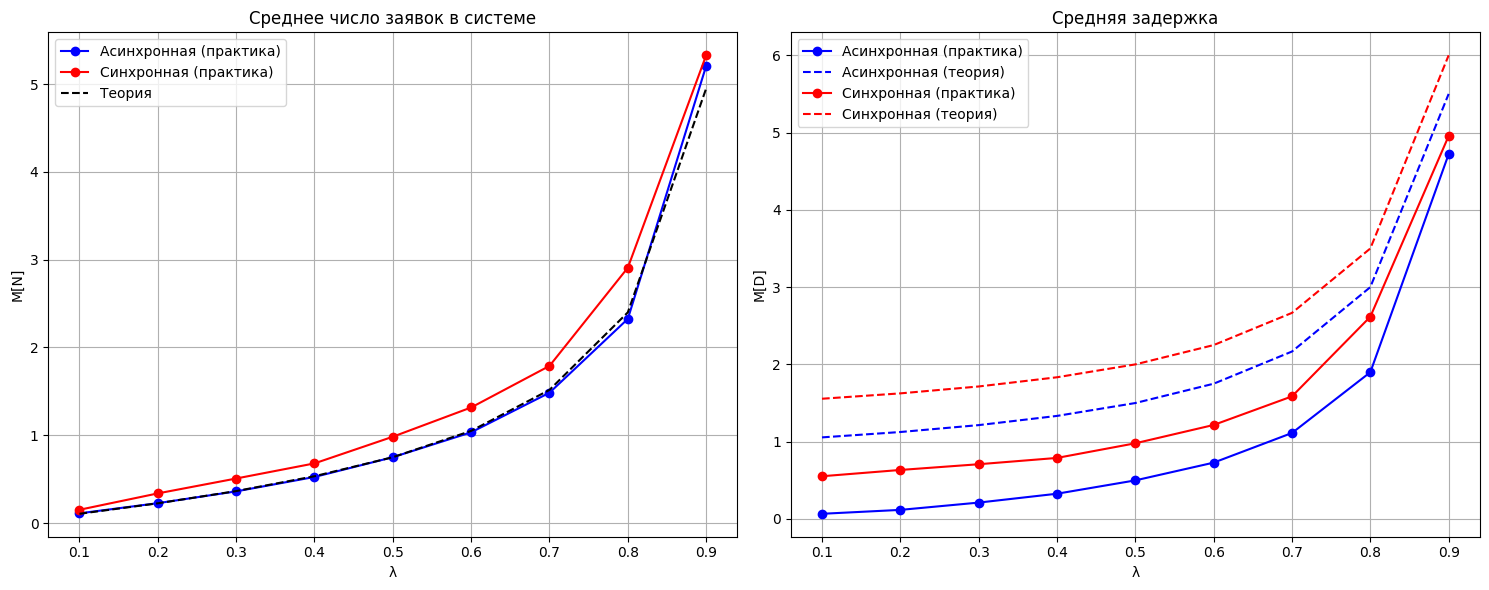

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = 1  # фиксированное время обслуживания
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, simulation_time: float) -> List[float]:
        """Генерация моментов прихода заявок"""
        times = []
        current_time = 0
        while current_time < simulation_time:
            interval = np.random.exponential(1/self.lambda_param)
            current_time += interval
            if current_time < simulation_time:
                times.append(current_time)
        return times
    
    def simulate(self, simulation_time: float):
        """Моделирование работы СМО"""
        arrival_times = self.generate_arrival_times(simulation_time)
        
        for arrival_time in arrival_times:
            request = Request(arrival_time=arrival_time)
            
            # Определение времени начала обслуживания
            if not self.completed_requests:
                if self.is_synchronous:
                    service_start = np.ceil(arrival_time)
                else:
                    service_start = arrival_time
            else:
                last_end_time = self.completed_requests[-1].service_end_time
                if self.is_synchronous:
                    service_start = max(np.ceil(arrival_time), np.ceil(last_end_time))
                else:
                    service_start = max(arrival_time, last_end_time)
            
            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.completed_requests.append(request)
            
    def calculate_metrics(self) -> Tuple[float, float]:
        """Вычисление метрик M[D] и M[N]"""
        if not self.completed_requests:
            return 0, 0
            
        # M[D] - средняя задержка
        delays = [req.service_start_time - req.arrival_time 
                 for req in self.completed_requests]
        mean_delay = np.mean(delays)
        
        # M[N] - среднее число заявок в системе
        events = []
        for req in self.completed_requests:
            events.append((req.arrival_time, 1))
            events.append((req.service_end_time, -1))
        
        events.sort()
        current_requests = 0
        total_area = 0
        last_time = events[0][0]
        
        for time, change in events:
            total_area += current_requests * (time - last_time)
            current_requests += change
            last_time = time
            
        mean_requests = total_area / events[-1][0]
        
        return mean_delay, mean_requests

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    """Вычисление теоретических значений"""
    # M[N] - общее для обоих типов систем
    N = lambda_param * (2 - lambda_param) / (2 * (1 - lambda_param))
    
    # M[D] для асинхронной и синхронной систем
    D_async = N / lambda_param
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], simulation_time: float = 10000):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nРезультаты моделирования:")
    print("λ\t| M[N] теор\t| M[N] async\t| M[N] sync\t| M[D] async теор\t| M[D] async практ\t| M[D] sync теор\t| M[D] sync практ")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        # Моделирование систем с увеличенным временем симуляции
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        async_system.simulate(simulation_time)
        D_async, N_async = async_system.calculate_metrics()
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        sync_system.simulate(simulation_time)
        D_sync, N_sync = sync_system.calculate_metrics()
        
        # Теоретические значения
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        # Сохранение результатов
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    """Построение графиков"""
    plt.figure(figsize=(15, 6))
    
    # График M[N]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Теория')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Среднее число заявок в системе')
    plt.legend()
    plt.grid(True)
    
    # График M[D]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Асинхронная (теория)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Синхронная (теория)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Средняя задержка')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# Запуск моделирования
if __name__ == "__main__":
    lambda_params = np.linspace(0.1, 0.9, 9)
    results = compare_systems(lambda_params)
    plot_results(lambda_params, results)

### Хорошая версия 1


Результаты моделирования:
λ	| M[N] теор	| M[N] async	| M[N] sync	| M[D] async теор	| M[D] async практ	| M[D] sync теор	| M[D] sync практ
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.105	| 0.154	| 1.056	| 0.049	| 1.556	| 0.558
0.2	| 0.225	| 0.229	| 0.323	| 1.125	| 0.131	| 1.625	| 0.626
0.3	| 0.364	| 0.363	| 0.512	| 1.214	| 0.210	| 1.714	| 0.708
0.4	| 0.533	| 0.541	| 0.741	| 1.333	| 0.343	| 1.833	| 0.844
0.5	| 0.750	| 0.737	| 1.000	| 1.500	| 0.490	| 2.000	| 0.995
0.6	| 1.050	| 1.037	| 1.345	| 1.750	| 0.733	| 2.250	| 1.245
0.7	| 1.517	| 1.533	| 1.872	| 2.167	| 1.183	| 2.667	| 1.674
0.8	| 2.400	| 2.316	| 2.918	| 3.000	| 1.909	| 3.500	| 2.627
0.9	| 4.950	| 5.070	| 5.185	| 5.500	| 4.614	| 6.000	| 4.801


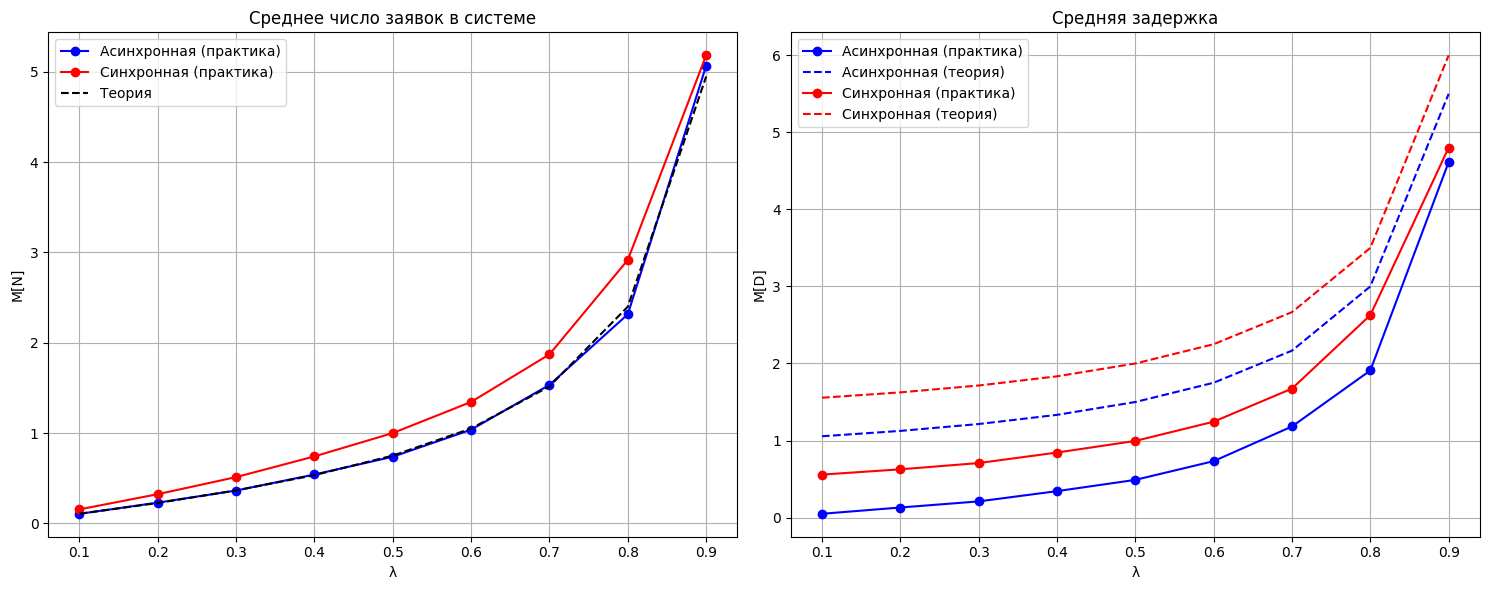

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = 1  # фиксированное время обслуживания
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, simulation_time: float) -> List[float]:
        """Генерация моментов прихода заявок"""
        times = []
        current_time = 0
        while current_time < simulation_time:
            interval = np.random.exponential(1/self.lambda_param)
            current_time += interval
            if current_time < simulation_time:
                times.append(current_time)
        return times
    
    def simulate(self, simulation_time: float):
        """Моделирование работы СМО"""
        arrival_times = self.generate_arrival_times(simulation_time)
        
        for arrival_time in arrival_times:
            request = Request(arrival_time=arrival_time)
            
            # Определение времени начала обслуживания
            if not self.completed_requests:
                if self.is_synchronous:
                    # В синхронной системе начало обслуживания округляется вверх
                    service_start = np.ceil(arrival_time)
                else:
                    # В асинхронной системе обслуживание начинается сразу
                    service_start = arrival_time
            else:
                last_end_time = self.completed_requests[-1].service_end_time
                if self.is_synchronous:
                    # Для синхронной системы учитываем и окно времени
                    service_start = max(np.ceil(arrival_time), last_end_time)
                else:
                    # Для асинхронной просто ждем освобождения сервера
                    service_start = max(arrival_time, last_end_time)
            
            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.completed_requests.append(request)
            
    def calculate_metrics(self) -> Tuple[float, float]:
        """Вычисление метрик M[D] и M[N]"""
        if not self.completed_requests:
            return 0, 0
            
        # M[D] - средняя задержка (от прихода до начала обслуживания)
        delays = [req.service_start_time - req.arrival_time 
                 for req in self.completed_requests]
        mean_delay = np.mean(delays)
        
        # M[N] - среднее число заявок в системе
        events = []
        for req in self.completed_requests:
            events.append((req.arrival_time, 1))     # приход заявки
            events.append((req.service_end_time, -1))  # уход заявки
        
        events.sort()
        current_requests = 0
        total_area = 0
        last_time = events[0][0]
        
        for time, change in events:
            total_area += current_requests * (time - last_time)
            current_requests += change
            last_time = time
            
        simulation_time = events[-1][0] - events[0][0]
        mean_requests = total_area / simulation_time
        
        return mean_delay, mean_requests

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    """Вычисление теоретических значений"""
    # M[N] - общее для обоих типов систем
    N = lambda_param * (2 - lambda_param) / (2 * (1 - lambda_param))
    
    # M[D] для асинхронной и синхронной систем
    D_async = N / lambda_param
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], simulation_time: float = 10000):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nРезультаты моделирования:")
    print("λ\t| M[N] теор\t| M[N] async\t| M[N] sync\t| M[D] async теор\t| M[D] async практ\t| M[D] sync теор\t| M[D] sync практ")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        # Моделирование систем
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        async_system.simulate(simulation_time)
        D_async, N_async = async_system.calculate_metrics()
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        sync_system.simulate(simulation_time)
        D_sync, N_sync = sync_system.calculate_metrics()
        
        # Теоретические значения
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        # Сохранение результатов
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    """Построение графиков"""
    plt.figure(figsize=(15, 6))
    
    # График M[N]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Теория')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Среднее число заявок в системе')
    plt.legend()
    plt.grid(True)
    
    # График M[D]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Асинхронная (теория)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Синхронная (теория)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Средняя задержка')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lambda_params = np.linspace(0.1, 0.9, 9)
    results = compare_systems(lambda_params, simulation_time=50000)  # Увеличено время симуляции
    plot_results(lambda_params, results)

### Исправления 1


Результаты моделирования:
λ	| M[N] теор	| M[N] async	| M[N] sync	| M[D] async теор	| M[D] async практ	| M[D] sync теор	| M[D] sync практ
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.104	| 0.155	| 1.056	| 1.057	| 1.556	| 1.555
0.2	| 0.225	| 0.229	| 0.322	| 1.125	| 1.129	| 1.625	| 1.620
0.3	| 0.364	| 0.366	| 0.519	| 1.214	| 1.219	| 1.714	| 1.705
0.4	| 0.533	| 0.540	| 0.745	| 1.333	| 1.340	| 1.833	| 1.841
0.5	| 0.750	| 0.755	| 0.995	| 1.500	| 1.513	| 2.000	| 1.992
0.6	| 1.050	| 1.047	| 1.315	| 1.750	| 1.746	| 2.250	| 2.210
0.7	| 1.517	| 1.487	| 1.880	| 2.167	| 2.127	| 2.667	| 2.701
0.8	| 2.400	| 2.342	| 2.910	| 3.000	| 2.939	| 3.500	| 3.616
0.9	| 4.950	| 4.986	| 5.038	| 5.500	| 5.554	| 6.000	| 5.623


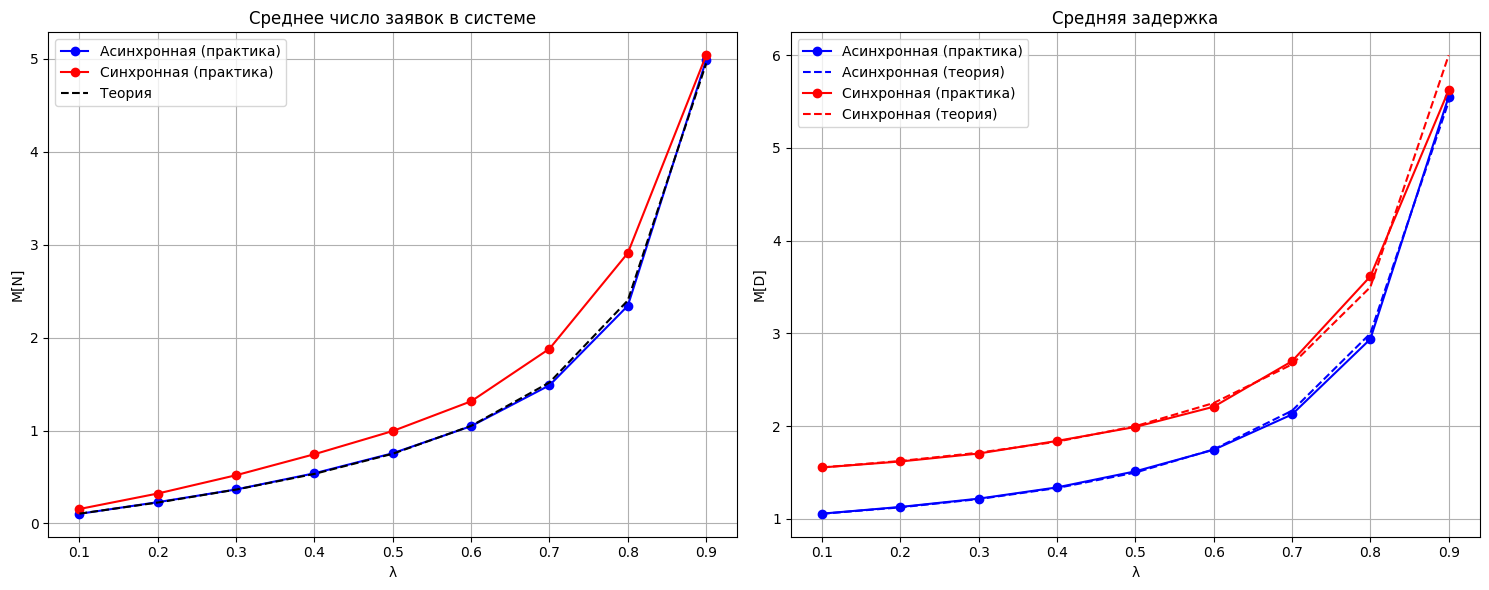

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = 1.0  # Время обслуживания (вынесено в отдельную переменную)
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []

    def generate_arrival_times(self, simulation_time: float) -> List[float]:
        times = []
        current_time = 0
        while current_time < simulation_time:
            interval = np.random.exponential(1/self.lambda_param)
            current_time += interval
            if current_time < simulation_time:
                times.append(current_time)
        return times

    def simulate(self, simulation_time: float):
        arrival_times = self.generate_arrival_times(simulation_time)

        for arrival_time in arrival_times:
            request = Request(arrival_time=arrival_time)

            if not self.completed_requests:
                if self.is_synchronous:
                    service_start = np.ceil(arrival_time)
                else:
                    service_start = arrival_time
            else:
                last_end_time = self.completed_requests[-1].service_end_time
                if self.is_synchronous:
                    service_start = max(np.ceil(arrival_time), last_end_time)  # Исправлено вычисление времени старта
                else:
                    service_start = max(arrival_time, last_end_time)

            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.completed_requests.append(request)

    def calculate_metrics(self) -> Tuple[float, float]:
        if not self.completed_requests:
            return 0, 0

        delays = [req.service_end_time - req.arrival_time for req in self.completed_requests] # Добавлено время обслуживания к задержке
        mean_delay = np.mean(delays)

        events = []
        for req in self.completed_requests:
            events.append((req.arrival_time, 1))
            events.append((req.service_end_time, -1))

        events.sort()
        current_requests = 0
        total_area = 0
        last_time = 0  # Начинаем с 0

        for time, change in events:
            total_area += current_requests * (time - last_time)
            current_requests += change
            last_time = time

        simulation_time = self.completed_requests[-1].service_end_time # Исправлено время симуляции
        mean_requests = total_area / simulation_time

        return mean_delay, mean_requests

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    """Вычисление теоретических значений"""
    # M[N] - общее для обоих типов систем
    N = lambda_param * (2 - lambda_param) / (2 * (1 - lambda_param))
    
    # M[D] для асинхронной и синхронной систем
    D_async = N / lambda_param
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], simulation_time: float = 10000):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nРезультаты моделирования:")
    print("λ\t| M[N] теор\t| M[N] async\t| M[N] sync\t| M[D] async теор\t| M[D] async практ\t| M[D] sync теор\t| M[D] sync практ")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        # Моделирование систем
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        async_system.simulate(simulation_time)
        D_async, N_async = async_system.calculate_metrics()
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        sync_system.simulate(simulation_time)
        D_sync, N_sync = sync_system.calculate_metrics()
        
        # Теоретические значения
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        # Сохранение результатов
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    """Построение графиков"""
    plt.figure(figsize=(15, 6))
    
    # График M[N]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Теория')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Среднее число заявок в системе')
    plt.legend()
    plt.grid(True)
    
    # График M[D]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Асинхронная (теория)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Синхронная (теория)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Средняя задержка')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lambda_params = np.linspace(0.1, 0.9, 9)
    results = compare_systems(lambda_params, simulation_time=50000)  # Увеличено время симуляции
    plot_results(lambda_params, results)

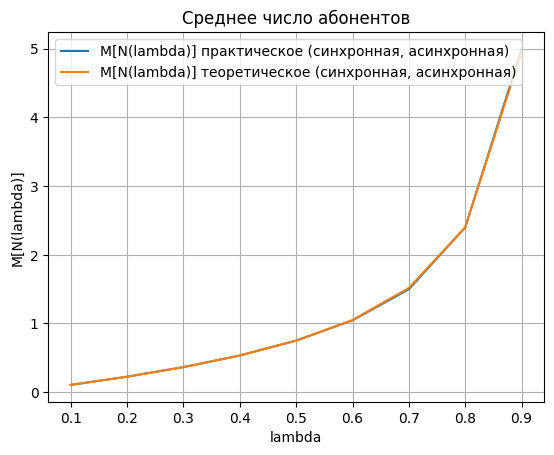

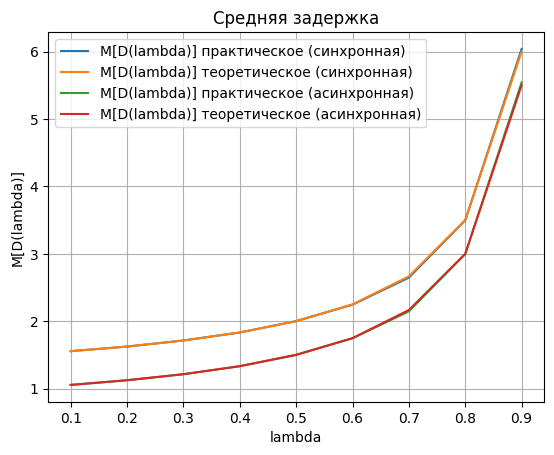

In [1]:
import random
from matplotlib import pyplot as plt
from numpy.random import poisson


class SimulationQueuingSystem:
    def __init__(self, N, lambda_val):
        self.N = N
        self.lambda_val = lambda_val
        self.message = 10 * lambda_val * N

    @staticmethod
    def synchronous_system(N, lambda_val):

        number_subscribers = poisson(lam=lambda_val, size=N)

        time = 0
        queue_synchr = []
        queue_asynchr = []
        delay_synchr = []
        delay_asynchr = []
        cur_quantity_subscribers = []

        differ = 0
        last_size = 0
        for cur_N in range(0, N):
            if last_size == 0:
                isLast = True
            else:
                isLast = False

            last_size = len(queue_asynchr)
            for subscriber in range(0, number_subscribers[cur_N]):
                queue_asynchr.append((subscriber, time + random.random()))
                queue_synchr.append((subscriber, time + random.random()))
            queue_synchr = [second for first, second in sorted((value[1], value) for value in queue_synchr)]
            queue_asynchr = [second for first, second in sorted((value[1], value) for value in queue_synchr)]

            if len(queue_synchr) != 0:
                if queue_synchr[0][1] < time:

                    delay_synchr.append(time - queue_synchr[0][1] + 1)
                    queue_synchr.pop(0)

                    if isLast:
                        delay_asynchr.append(1)
                        differ = queue_asynchr[0][1] + 1
                    elif differ > queue_asynchr[0][1]:
                        delay_asynchr.append(differ - queue_asynchr[0][1] + 1)
                        differ += 1
                    else:
                        delay_asynchr.append(1)
                        differ = queue_asynchr[0][1] + 1

                    queue_asynchr.pop(0)

            cur_quantity_subscribers += [len(queue_synchr)]

            time += 1
        M_D_synchr = sum(delay_synchr) / len(delay_synchr)
        M_N_all = sum(cur_quantity_subscribers) / len(cur_quantity_subscribers)
        M_N_theor_all = (lambda_val * (2 - lambda_val)) / (2 * (1 - lambda_val))
        M_D_theor_synchr = (M_N_theor_all / lambda_val) + 0.5

        M_D_asynchr = sum(delay_asynchr) / len(delay_asynchr)
        M_N_asynchr = sum(cur_quantity_subscribers) / len(cur_quantity_subscribers)
        M_D_theor_asynchr = (M_N_theor_all / lambda_val)

        return M_N_all, M_N_theor_all, M_D_synchr, M_D_theor_synchr, M_D_asynchr, M_D_theor_asynchr

N = 900000
list_M_N__M_N_theor__M_D__M_D_theor = []

SimulationQueuingSystem.synchronous_system(N, 0.9)

for lambda_val in range(1, 10):
    list_M_N__M_N_theor__M_D__M_D_theor += [(SimulationQueuingSystem.synchronous_system(N, lambda_val / 10))]

plt.plot([lambda_val / 10 for lambda_val in range(1, 10)], [val[0] for val in list_M_N__M_N_theor__M_D__M_D_theor], label="M[N(lambda)] практическое (синхронная, асинхронная)")
plt.plot([lambda_val / 10 for lambda_val in range(1, 10)], [val[1] for val in list_M_N__M_N_theor__M_D__M_D_theor], label="M[N(lambda)] теоретическое (синхронная, асинхронная)")
plt.title('Среднее число абонентов')
plt.xlabel("lambda")
plt.ylabel("M[N(lambda)]")
plt.grid()
plt.legend()
plt.show()

plt.plot([lambda_val / 10 for lambda_val in range(1, 10)], [val[2] for val in list_M_N__M_N_theor__M_D__M_D_theor], label="M[D(lambda)] практическое (синхронная)")
plt.plot([lambda_val / 10 for lambda_val in range(1, 10)], [val[3] for val in list_M_N__M_N_theor__M_D__M_D_theor], label="M[D(lambda)] теоретическое (синхронная)")
plt.plot([lambda_val / 10 for lambda_val in range(1, 10)], [val[4] for val in list_M_N__M_N_theor__M_D__M_D_theor], label="M[D(lambda)] практическое (асинхронная)")
plt.plot([lambda_val / 10 for lambda_val in range(1, 10)], [val[5] for val in list_M_N__M_N_theor__M_D__M_D_theor], label="M[D(lambda)] теоретическое (асинхронная)")
plt.title('Средняя задержка')
plt.xlabel("lambda")
plt.ylabel("M[D(lambda)]")
plt.grid()
plt.legend()
plt.show()


## Fix


Simulation Results:
λ	| M[N] theory	| M[N] async	| M[N] sync	| M[D] async theory	| M[D] async practice	| M[D] sync theory	| M[D] sync practice
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.109	| 0.154	| 1.056	| 1.053	| 1.556	| 1.549
0.2	| 0.225	| 0.225	| 0.325	| 1.125	| 1.125	| 1.625	| 1.629
0.3	| 0.364	| 0.361	| 0.510	| 1.214	| 1.216	| 1.714	| 1.710
0.4	| 0.533	| 0.532	| 0.719	| 1.333	| 1.335	| 1.833	| 1.826
0.5	| 0.750	| 0.740	| 1.000	| 1.500	| 1.490	| 2.000	| 1.999
0.6	| 1.050	| 1.029	| 1.310	| 1.750	| 1.720	| 2.250	| 2.213
0.7	| 1.517	| 1.549	| 1.854	| 2.167	| 2.206	| 2.667	| 2.662
0.8	| 2.400	| 2.279	| 2.815	| 3.000	| 2.867	| 3.500	| 3.503
0.9	| 4.950	| 5.122	| 5.100	| 5.500	| 5.660	| 6.000	| 5.677


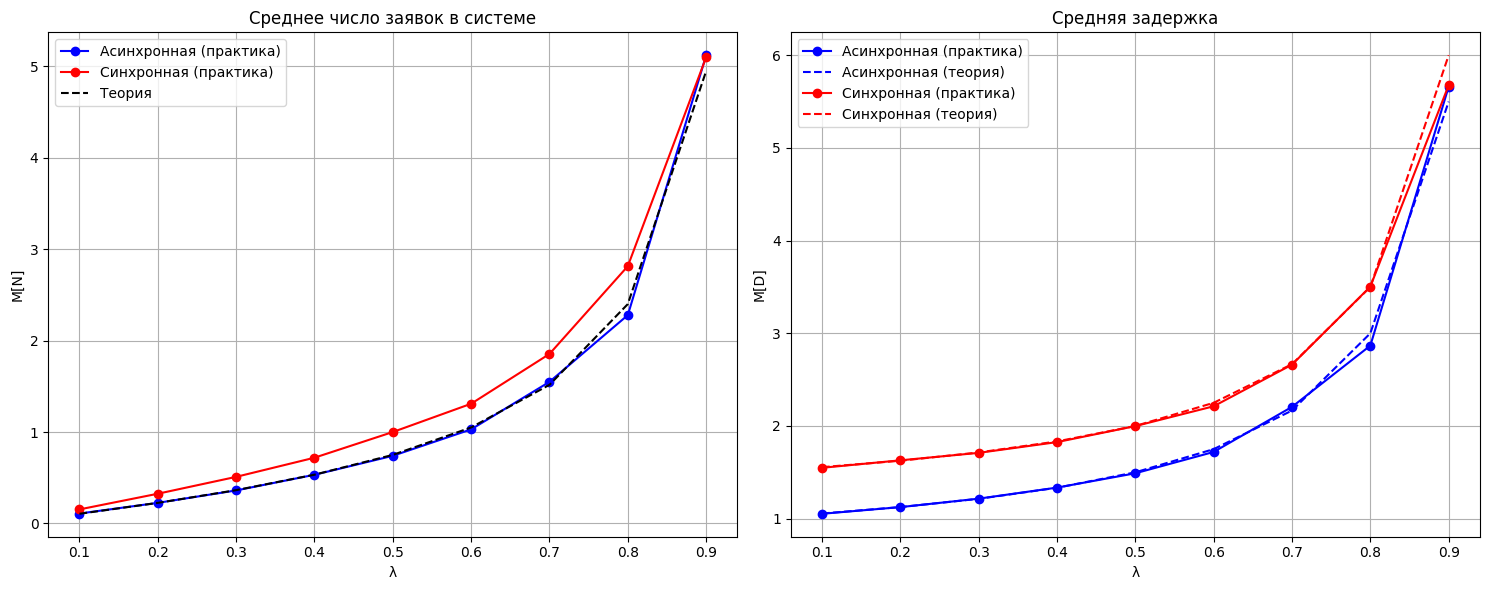

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, mu: float = 1.0, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = mu  # Service rate (explicitly defined)
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []

    def generate_arrival_times(self, simulation_time: float) -> List[float]:
        times = []
        current_time = 0
        while current_time < simulation_time:
            interval = np.random.exponential(1/self.lambda_param)
            current_time += interval
            if current_time < simulation_time:  # Only add if within simulation time
                times.append(current_time)
        return times

    def simulate(self, simulation_time: float):
        arrival_times = self.generate_arrival_times(simulation_time)
        for arrival_time in arrival_times:
            request = Request(arrival_time=arrival_time)
            if not self.completed_requests:
                if self.is_synchronous:
                    service_start = np.ceil(arrival_time)
                else:
                    service_start = arrival_time
            else:
                last_end_time = self.completed_requests[-1].service_end_time
                if self.is_synchronous:
                    service_start = max(np.ceil(arrival_time), last_end_time)
                else:
                    service_start = max(arrival_time, last_end_time)

            request.service_start_time = service_start
            request.service_end_time = service_start + self.mu
            self.completed_requests.append(request)


    def calculate_metrics(self, simulation_time: float) -> Tuple[float, float]:
        if not self.completed_requests:
            return 0, 0

        delays = [req.service_end_time - req.arrival_time for req in self.completed_requests]
        mean_delay = np.mean(delays)

        events = []
        for req in self.completed_requests:
            events.append((req.arrival_time, 1))
            events.append((req.service_end_time, -1))

        events.sort()
        current_requests = 0
        total_area = 0
        last_time = 0

        for time, change in events:
            total_area += current_requests * (time - last_time)
            current_requests += change
            last_time = time


        mean_requests = total_area / simulation_time # Correct simulation time usage

        return mean_delay, mean_requests

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    """Calculates theoretical values."""
    N = lambda_param * (2 - lambda_param) / (2 * (1 - lambda_param))
    D_async = N / lambda_param
    D_sync = D_async + 0.5
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], simulation_time: float = 50000):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }

    print("\nSimulation Results:")
    print("λ\t| M[N] theory\t| M[N] async\t| M[N] sync\t| M[D] async theory\t| M[D] async practice\t| M[D] sync theory\t| M[D] sync practice")
    print("-" * 120)

    for lambda_param in lambda_params:
        # System Simulation
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        async_system.simulate(simulation_time)
        D_async, N_async = async_system.calculate_metrics(simulation_time) # Pass simulation_time

        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        sync_system.simulate(simulation_time)
        D_sync, N_sync = sync_system.calculate_metrics(simulation_time) # Pass simulation_time

        # Theoretical Values
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)

        # Store Results
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)

        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")

    return results

def plot_results(lambda_params: List[float], results: dict):
    """Построение графиков"""
    plt.figure(figsize=(15, 6))
    
    # График M[N]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Теория')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Среднее число заявок в системе')
    plt.legend()
    plt.grid(True)
    
    # График M[D]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Асинхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Асинхронная (теория)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Синхронная (практика)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Синхронная (теория)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Средняя задержка')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lambda_params = np.linspace(0.1, 0.9, 9)
    results = compare_systems(lambda_params)
    plot_results(lambda_params, results)


Simulation Results:
λ	| M[N] theory	| M[N] async	| M[N] sync	| M[D] async theory	| M[D] async pract	| M[D] sync theory	| M[D] sync pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.105	| 0.154	| 1.056	| 1.055	| 1.556	| 1.554
0.2	| 0.225	| 0.225	| 0.326	| 1.125	| 1.123	| 1.625	| 1.627
0.3	| 0.364	| 0.364	| 0.513	| 1.214	| 1.214	| 1.714	| 1.712
0.4	| 0.533	| 0.534	| 0.735	| 1.333	| 1.334	| 1.833	| 1.834
0.5	| 0.750	| 0.751	| 0.999	| 1.500	| 1.500	| 2.000	| 1.997
0.6	| 1.050	| 1.054	| 1.351	| 1.750	| 1.754	| 2.250	| 2.250
0.7	| 1.517	| 1.517	| 1.856	| 2.167	| 2.169	| 2.667	| 2.655
0.8	| 2.400	| 2.377	| 2.805	| 3.000	| 2.977	| 3.500	| 3.501
0.9	| 4.950	| 4.871	| 5.566	| 5.500	| 5.420	| 6.000	| 6.172


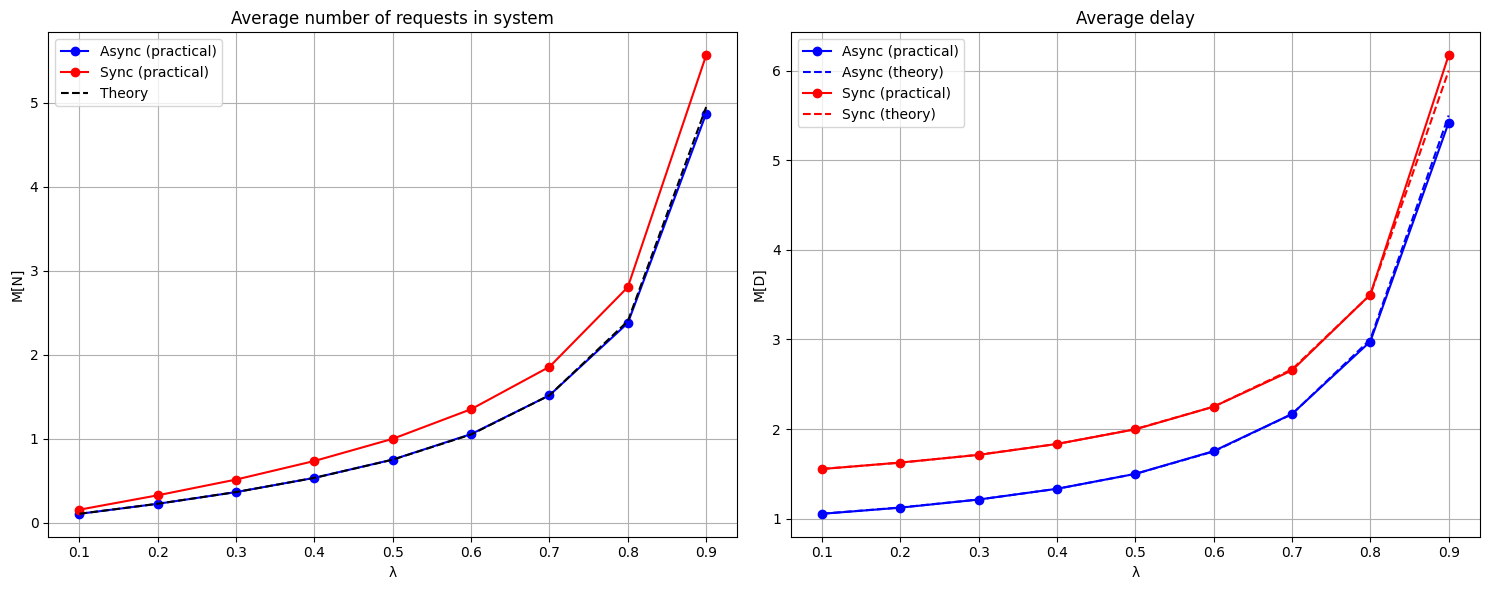

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import random

@dataclass
class Request:
    id: int
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.is_synchronous = is_synchronous
        self.completed_requests: List[Request] = []
        
    def simulate(self, simulation_time: int):
        # Generate number of arrivals for each time slot using Poisson distribution
        arrivals_per_slot = np.random.poisson(self.lambda_param, simulation_time)
        
        queue = []
        current_id = 0
        
        # For each time slot
        for time in range(simulation_time):
            # Generate new arrivals for this time slot
            for _ in range(arrivals_per_slot[time]):
                arrival_time = time + random.random()  # Random arrival within the slot
                request = Request(id=current_id, arrival_time=arrival_time)
                queue.append(request)
                current_id += 1
            
            # Sort queue by arrival time
            queue.sort(key=lambda x: x.arrival_time)
            
            # Process request if queue is not empty
            if queue:
                request = queue[0]
                if self.is_synchronous:
                    # For synchronous system, service starts at next integer time
                    if not self.completed_requests:
                        service_start = np.ceil(request.arrival_time)
                    else:
                        service_start = max(np.ceil(request.arrival_time), 
                                         self.completed_requests[-1].service_end_time)
                else:
                    # For asynchronous system, service starts immediately if possible
                    if not self.completed_requests:
                        service_start = request.arrival_time
                    else:
                        service_start = max(request.arrival_time,
                                         self.completed_requests[-1].service_end_time)
                
                request.service_start_time = service_start
                request.service_end_time = service_start + 1  # Service time is 1
                
                self.completed_requests.append(queue.pop(0))

    def calculate_metrics(self) -> Tuple[float, float]:
        if not self.completed_requests:
            return 0, 0

        # Calculate mean delay
        delays = [req.service_end_time - req.arrival_time for req in self.completed_requests]
        mean_delay = np.mean(delays)

        # Calculate mean number of requests in system
        events = []
        for req in self.completed_requests:
            events.append((req.arrival_time, 1))    # Arrival: +1 to queue
            events.append((req.service_end_time, -1))  # Departure: -1 from queue
        
        events.sort()
        current_requests = 0
        total_area = 0
        last_time = events[0][0]

        for time, change in events:
            total_area += current_requests * (time - last_time)
            current_requests += change
            last_time = time

        simulation_time = events[-1][0]
        mean_requests = total_area / simulation_time

        return mean_delay, mean_requests

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    """Calculate theoretical values"""
    # M[N] is the same for both systems
    N = lambda_param * (2 - lambda_param) / (2 * (1 - lambda_param))
    
    # M[D] for async and sync systems
    D_async = N / lambda_param
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], simulation_time: int = 900000):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nSimulation Results:")
    print("λ\t| M[N] theory\t| M[N] async\t| M[N] sync\t| M[D] async theory\t| M[D] async pract\t| M[D] sync theory\t| M[D] sync pract")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        # Simulate systems
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        async_system.simulate(simulation_time)
        D_async, N_async = async_system.calculate_metrics()
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        sync_system.simulate(simulation_time)
        D_sync, N_sync = sync_system.calculate_metrics()
        
        # Calculate theoretical values
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        # Store results
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    """Plot results"""
    plt.figure(figsize=(15, 6))
    
    # Plot M[N]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Async (practical)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Sync (practical)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Theory')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Average number of requests in system')
    plt.legend()
    plt.grid(True)
    
    # Plot M[D]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Async (practical)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Async (theory)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Sync (practical)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Sync (theory)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Average delay')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lambda_params = [i/10 for i in range(1, 10)]  # From 0.1 to 0.9
    results = compare_systems(lambda_params, simulation_time=900000)
    plot_results(lambda_params, results)


Simulation Results:
λ	| M[N] theory	| M[N] practical	| M[D] sync theory	| M[D] sync pract	| M[D] async theory	| M[D] async pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.106	| 1.556	| 1.557	| 1.056	| 1.056
0.2	| 0.225	| 0.225	| 1.625	| 1.625	| 1.125	| 1.125
0.3	| 0.364	| 0.365	| 1.714	| 1.715	| 1.214	| 1.215
0.4	| 0.533	| 0.533	| 1.833	| 1.832	| 1.333	| 1.333
0.5	| 0.750	| 0.753	| 2.000	| 2.000	| 1.500	| 1.500
0.6	| 1.050	| 1.049	| 2.250	| 2.250	| 1.750	| 1.751
0.7	| 1.517	| 1.511	| 2.667	| 2.661	| 2.167	| 2.162
0.8	| 2.400	| 2.406	| 3.500	| 3.507	| 3.000	| 3.010
0.9	| 4.950	| 4.885	| 6.000	| 5.929	| 5.500	| 5.425


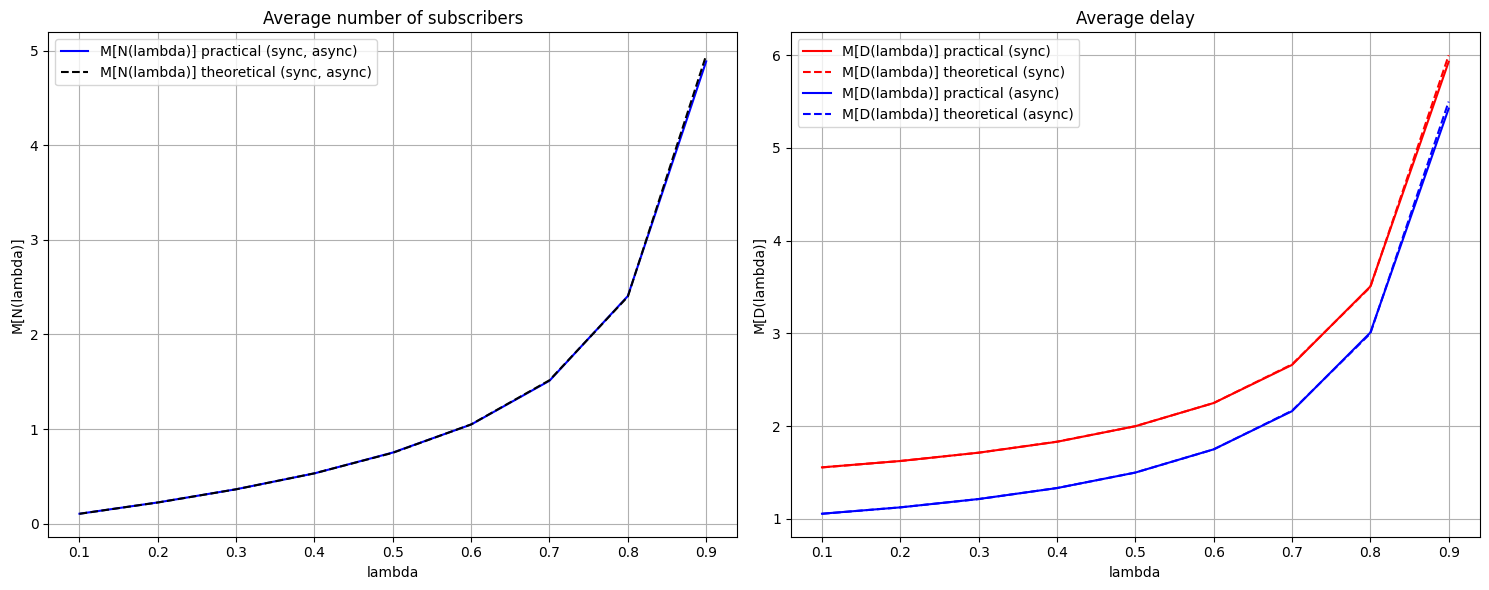

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
import random

@dataclass
class Request:
    id: int
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float):
        self.lambda_param = lambda_param
        self.queue_length_history = []
        self.sync_delays = []
        self.async_delays = []
        
    def simulate(self, simulation_time: int):
        # Generate number of arrivals for each time slot using Poisson distribution
        arrivals_per_slot = np.random.poisson(self.lambda_param, simulation_time)
        
        queue = []
        current_id = 0
        differ = 0  # For tracking async service times
        last_queue_size = 0
        
        # For each time slot
        for time in range(simulation_time):
            if last_queue_size == 0:
                is_last = True
            else:
                is_last = False
            last_queue_size = len(queue)
            
            # Generate new arrivals for this time slot
            for _ in range(arrivals_per_slot[time]):
                arrival_time = time + random.random()  # Random arrival within the slot
                request = Request(id=current_id, arrival_time=arrival_time)
                queue.append(request)
                current_id += 1
            
            # Sort queue by arrival time
            queue.sort(key=lambda x: x.arrival_time)
            
            # Process request if queue is not empty
            if queue:
                request = queue[0]
                if request.arrival_time < time:
                    # Calculate delays for both sync and async systems
                    self.sync_delays.append(time - request.arrival_time + 1)
                    
                    if is_last:
                        self.async_delays.append(1)
                        differ = request.arrival_time + 1
                    elif differ > request.arrival_time:
                        self.async_delays.append(differ - request.arrival_time + 1)
                        differ += 1
                    else:
                        self.async_delays.append(1)
                        differ = request.arrival_time + 1
                    
                    queue.pop(0)
            
            # Record current queue length
            self.queue_length_history.append(len(queue))

    def calculate_metrics(self) -> Tuple[float, float, float, float, float]:
        if not self.queue_length_history:
            return 0, 0, 0, 0, 0

        # Calculate M[N] - same for both sync and async
        M_N_all = sum(self.queue_length_history) / len(self.queue_length_history)
        
        # Calculate theoretical M[N]
        M_N_theor_all = (self.lambda_param * (2 - self.lambda_param)) / (2 * (1 - self.lambda_param))
        
        # Calculate delays
        M_D_sync = sum(self.sync_delays) / len(self.sync_delays)
        M_D_async = sum(self.async_delays) / len(self.async_delays)
        
        # Calculate theoretical delays
        M_D_theor_async = M_N_theor_all / self.lambda_param
        M_D_theor_sync = M_D_theor_async + 0.5

        return M_N_all, M_N_theor_all, M_D_sync, M_D_theor_sync, M_D_async, M_D_theor_async

def compare_systems(simulation_time: int = 900000):
    lambda_params = [i/10 for i in range(1, 10)]  # From 0.1 to 0.9
    results = []
    
    print("\nSimulation Results:")
    print("λ\t| M[N] theory\t| M[N] practical\t| M[D] sync theory\t| M[D] sync pract\t| M[D] async theory\t| M[D] async pract")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        # Single simulation for both sync and async
        system = QueueingSystem(lambda_param)
        system.simulate(simulation_time)
        M_N_all, M_N_theor_all, M_D_sync, M_D_theor_sync, M_D_async, M_D_theor_async = system.calculate_metrics()
        
        results.append((M_N_all, M_N_theor_all, M_D_sync, M_D_theor_sync, M_D_async, M_D_theor_async))
        
        print(f"{lambda_param:.1f}\t| {M_N_theor_all:.3f}\t| {M_N_all:.3f}\t| {M_D_theor_sync:.3f}\t| {M_D_sync:.3f}\t| {M_D_theor_async:.3f}\t| {M_D_async:.3f}")
    
    return lambda_params, results

def plot_results(lambda_params: List[float], results: List[tuple]):
    """Plot results"""
    plt.figure(figsize=(15, 6))
    
    # Plot M[N] - combined for sync and async
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, [r[0] for r in results], 'b-', 
             label='M[N(lambda)] practical (sync, async)')
    plt.plot(lambda_params, [r[1] for r in results], 'k--', 
             label='M[N(lambda)] theoretical (sync, async)')
    plt.xlabel('lambda')
    plt.ylabel('M[N(lambda)]')
    plt.title('Average number of subscribers')
    plt.grid(True)
    plt.legend()
    
    # Plot M[D]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, [r[2] for r in results], 'r-', 
             label='M[D(lambda)] practical (sync)')
    plt.plot(lambda_params, [r[3] for r in results], 'r--', 
             label='M[D(lambda)] theoretical (sync)')
    plt.plot(lambda_params, [r[4] for r in results], 'b-', 
             label='M[D(lambda)] practical (async)')
    plt.plot(lambda_params, [r[5] for r in results], 'b--', 
             label='M[D(lambda)] theoretical (async)')
    plt.xlabel('lambda')
    plt.ylabel('M[D(lambda)]')
    plt.title('Average delay')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lambda_params, results = compare_systems(simulation_time=900000)
    plot_results(lambda_params, results)


Результаты моделирования:
λ	| M[N] теор	| M[N] практ	| M[D] async теор	| M[D] async практ	| M[D] sync теор	| M[D] sync практ
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.106	| 1.056	| 1.056	| 1.556	| 1.558
0.2	| 0.225	| 0.224	| 1.125	| 1.124	| 1.625	| 1.624
0.3	| 0.364	| 0.364	| 1.214	| 1.214	| 1.714	| 1.716
0.4	| 0.533	| 0.533	| 1.333	| 1.332	| 1.833	| 1.831
0.5	| 0.750	| 0.751	| 1.500	| 1.503	| 2.000	| 2.003
0.6	| 1.050	| 1.052	| 1.750	| 1.751	| 2.250	| 2.249
0.7	| 1.517	| 1.521	| 2.167	| 2.173	| 2.667	| 2.672
0.8	| 2.400	| 2.397	| 3.000	| 2.994	| 3.500	| 3.495
0.9	| 4.950	| 4.990	| 5.500	| 5.540	| 6.000	| 6.041


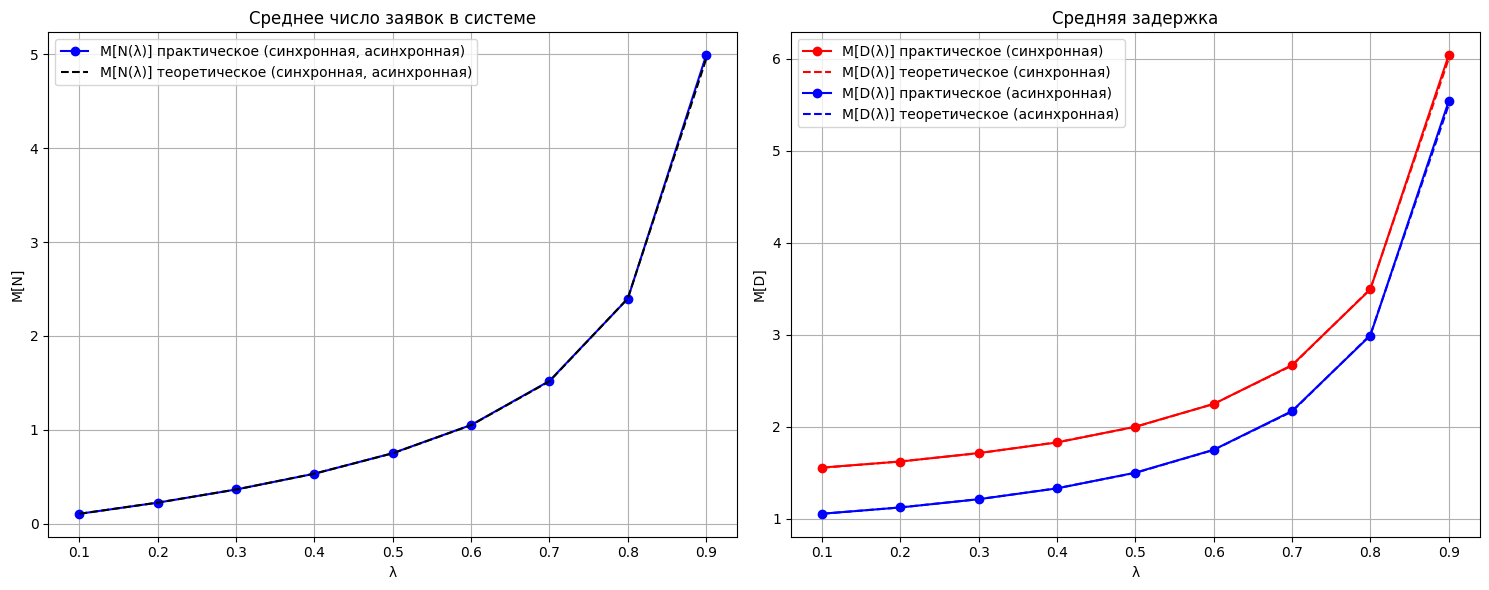

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float):
        self.lambda_param = lambda_param
        self.mu = 1.0
        self.queue = deque()
        self.completed_requests: List[Request] = []
        self.completed_requests_sync: List[Request] = []
        self.completed_requests_async: List[Request] = []

    def simulate(self, simulation_time: int):
        # Generate number of arrivals for each time slot using Poisson distribution
        time = 0
        number_subscribers = np.random.poisson(lam=self.lambda_param, size=simulation_time)
        
        queue_sync = []
        queue_async = []
        differ = 0
        last_size = 0
        
        # For each time slot
        for cur_time in range(simulation_time):
            if last_size == 0:
                is_last = True
            else:
                is_last = False
                
            last_size = len(queue_async)
            
            # Generate new arrivals for this time slot
            for _ in range(number_subscribers[cur_time]):
                arrival_time = time + np.random.random()
                queue_async.append((_, arrival_time))
                queue_sync.append((_, arrival_time))
            
            # Sort queues by arrival time
            queue_sync = [second for first, second in sorted((value[1], value) for value in queue_sync)]
            queue_async = [second for first, second in sorted((value[1], value) for value in queue_async)]
            
            # Process requests
            if len(queue_sync) != 0:
                if queue_sync[0][1] < time:
                    # Handle synchronous request
                    request_sync = Request(arrival_time=queue_sync[0][1])
                    request_sync.service_start_time = time
                    request_sync.service_end_time = time + 1
                    self.completed_requests_sync.append(request_sync)
                    queue_sync.pop(0)
                    
                    # Handle asynchronous request
                    request_async = Request(arrival_time=queue_async[0][1])
                    if is_last:
                        request_async.service_start_time = queue_async[0][1]
                        request_async.service_end_time = request_async.service_start_time + 1
                        differ = queue_async[0][1] + 1
                    elif differ > queue_async[0][1]:
                        request_async.service_start_time = differ
                        request_async.service_end_time = differ + 1
                        differ += 1
                    else:
                        request_async.service_start_time = queue_async[0][1]
                        request_async.service_end_time = request_async.service_start_time + 1
                        differ = queue_async[0][1] + 1
                    
                    self.completed_requests_async.append(request_async)
                    queue_async.pop(0)
            
            # Store current queue length for M[N] calculation
            request = Request(arrival_time=time)
            request.service_start_time = time
            request.service_end_time = time + 1
            self.completed_requests.append((request, len(queue_sync)))
            
            time += 1

    def calculate_metrics(self) -> Tuple[float, float, float]:
        if not self.completed_requests:
            return 0, 0, 0

        # Calculate M[N]
        queue_lengths = [req[1] for req in self.completed_requests]
        mean_requests = np.mean(queue_lengths)
        
        # Calculate delays for sync system
        delays_sync = [req.service_end_time - req.arrival_time 
                      for req in self.completed_requests_sync]
        mean_delay_sync = np.mean(delays_sync)
        
        # Calculate delays for async system
        delays_async = [req.service_end_time - req.arrival_time 
                       for req in self.completed_requests_async]
        mean_delay_async = np.mean(delays_async)

        return mean_requests, mean_delay_sync, mean_delay_async

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    """Calculate theoretical values"""
    # M[N] is the same for both systems
    N = lambda_param * (2 - lambda_param) / (2 * (1 - lambda_param))
    
    # M[D] for async and sync systems
    D_async = N / lambda_param
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], simulation_time: int = 900000):
    results = {
        'practice': {'N': [], 'D_sync': [], 'D_async': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nРезультаты моделирования:")
    print("λ\t| M[N] теор\t| M[N] практ\t| M[D] async теор\t| M[D] async практ\t| M[D] sync теор\t| M[D] sync практ")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        # Simulate system
        system = QueueingSystem(lambda_param)
        system.simulate(simulation_time)
        N_pract, D_sync_pract, D_async_pract = system.calculate_metrics()
        
        # Calculate theoretical values
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        # Store results
        results['practice']['N'].append(N_pract)
        results['practice']['D_sync'].append(D_sync_pract)
        results['practice']['D_async'].append(D_async_pract)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_pract:.3f}\t| {D_async_theory:.3f}\t| {D_async_pract:.3f}\t| {D_sync_theory:.3f}\t| {D_sync_pract:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    """Plot results"""
    plt.figure(figsize=(15, 6))
    
    # Plot M[N]
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['practice']['N'], 'bo-', label='M[N(λ)] практическое (синхронная, асинхронная)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='M[N(λ)] теоретическое (синхронная, асинхронная)')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Среднее число заявок в системе')
    plt.legend()
    plt.grid(True)
    
    # Plot M[D]
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['practice']['D_sync'], 'ro-', label='M[D(λ)] практическое (синхронная)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='M[D(λ)] теоретическое (синхронная)')
    plt.plot(lambda_params, results['practice']['D_async'], 'bo-', label='M[D(λ)] практическое (асинхронная)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='M[D(λ)] теоретическое (асинхронная)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Средняя задержка')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    lambda_params = [i/10 for i in range(1, 10)]  # From 0.1 to 0.9
    results = compare_systems(lambda_params, simulation_time=900000)
    plot_results(lambda_params, results)

## Fix 2


Simulation Results:
λ	| M[N] theor	| M[N] async	| M[N] sync	| M[D] async theor	| M[D] async pract	| M[D] sync theor	| M[D] sync pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.106	| 0.106	| 1.056	| 1.054	| 1.556	| 1.547
0.2	| 0.225	| 0.227	| 0.224	| 1.125	| 1.129	| 1.625	| 1.620
0.3	| 0.364	| 0.363	| 0.365	| 1.214	| 1.216	| 1.714	| 1.718
0.4	| 0.533	| 0.549	| 0.534	| 1.333	| 1.350	| 1.833	| 1.830
0.5	| 0.750	| 0.743	| 0.737	| 1.500	| 1.497	| 2.000	| 1.978
0.6	| 1.050	| 1.050	| 1.046	| 1.750	| 1.753	| 2.250	| 2.236
0.7	| 1.517	| 1.519	| 1.558	| 2.167	| 2.179	| 2.667	| 2.689
0.8	| 2.400	| 2.366	| 2.313	| 3.000	| 3.005	| 3.500	| 3.389
0.9	| 4.950	| 4.702	| 5.301	| 5.500	| 5.238	| 6.000	| 6.426


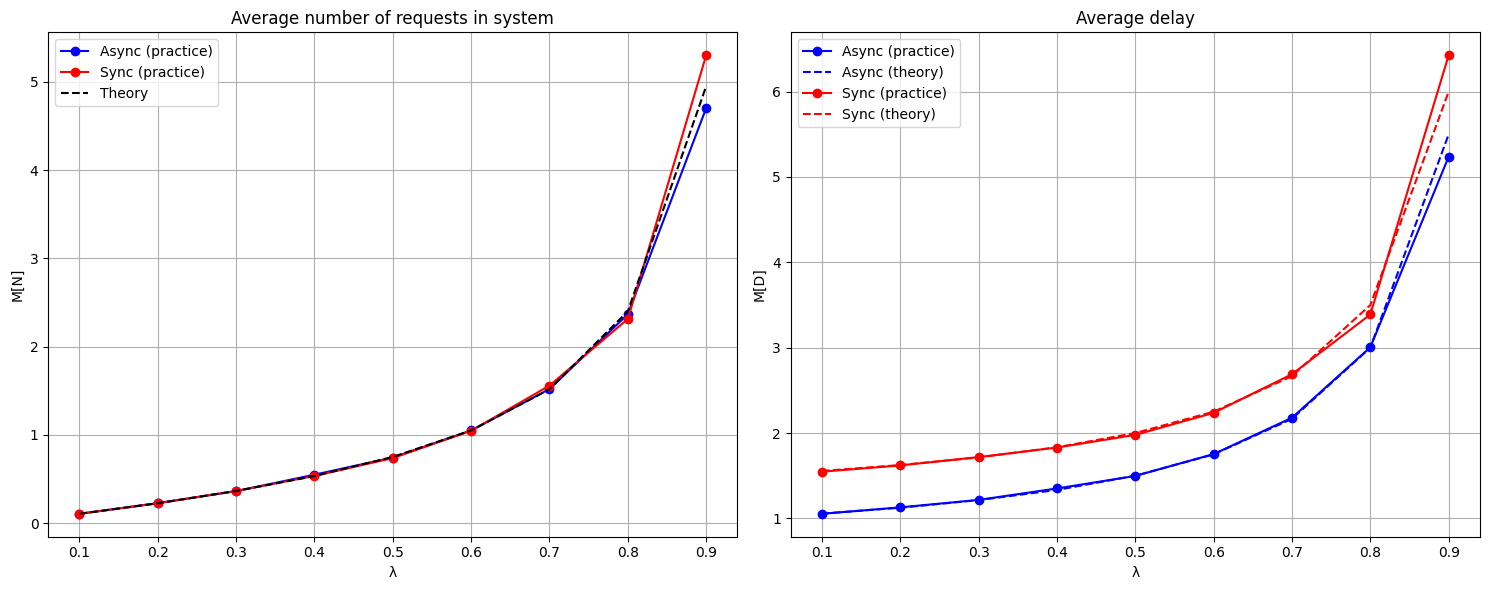

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = 1.0
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = deque()
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, size: int) -> List[float]:
        tau = np.random.exponential(1/self.lambda_param, size)
        return np.cumsum(tau)
        
    def calculate_average_messages(self, timeline: List[float]) -> float:
        M_N = 0
        cur_mes = 0
        number_windows = int(np.ceil(timeline[-1]))
        
        queue = deque()
        for i in range(number_windows):
            if queue:
                queue.popleft()
            while cur_mes < len(timeline) and timeline[cur_mes] < i:
                queue.append(cur_mes)
                cur_mes += 1
            M_N += len(queue)
            
        return M_N / number_windows if number_windows > 0 else 0

    def simulate(self, size: int = 100000):
        timeline = self.generate_arrival_times(size)
        times_send = [0.0]  # Start with initial time
        total_delay = 0
        
        t = np.ceil(timeline[0]) + 1
        total_delay += (t - timeline[0])
        times_send.append(t)
        
        for i in range(1, len(timeline)):
            if self.is_synchronous:
                t = np.ceil(timeline[i])
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    while t < times_send[-1] + 1:
                        t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
            else:  # Asynchronous
                t = timeline[i]
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    t = times_send[-1] + 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
        
        avg_delay = total_delay / size
        avg_messages = self.calculate_average_messages(timeline)
        
        return avg_delay, avg_messages

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    N = (lambda_param * (2 - lambda_param)) / (2 * (1 - lambda_param))
    
    D_async = (2 - lambda_param) / (2 * (1 - lambda_param))
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], size: int):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nSimulation Results:")
    print("λ\t| M[N] theor\t| M[N] async\t| M[N] sync\t| M[D] async theor\t| M[D] async pract\t| M[D] sync theor\t| M[D] sync pract")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        D_async, N_async = async_system.simulate(size)
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        D_sync, N_sync = sync_system.simulate(size)
        
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Theory')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Average number of requests in system')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Async (theory)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Sync (theory)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Average delay')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

lambda_params = np.linspace(0.1, 0.9, 9)
results = compare_systems(lambda_params, 10_000)
plot_results(lambda_params, results)


Simulation Results:
λ	| M[N] theor	| M[N] async	| M[N] sync	| M[D] async theor	| M[D] async pract	| M[D] sync theor	| M[D] sync pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.105	| 0.106	| 1.056	| 1.055	| 1.556	| 1.556
0.2	| 0.225	| 0.225	| 0.225	| 1.125	| 1.125	| 1.625	| 1.625
0.3	| 0.364	| 0.363	| 0.365	| 1.214	| 1.213	| 1.714	| 1.715
0.4	| 0.533	| 0.532	| 0.534	| 1.333	| 1.333	| 1.833	| 1.835
0.5	| 0.750	| 0.749	| 0.752	| 1.500	| 1.498	| 2.000	| 2.003
0.6	| 1.050	| 1.053	| 1.049	| 1.750	| 1.753	| 2.250	| 2.250
0.7	| 1.517	| 1.516	| 1.516	| 2.167	| 2.167	| 2.667	| 2.665
0.8	| 2.400	| 2.387	| 2.394	| 3.000	| 2.985	| 3.500	| 3.494
0.9	| 4.950	| 4.932	| 4.982	| 5.500	| 5.483	| 6.000	| 6.034


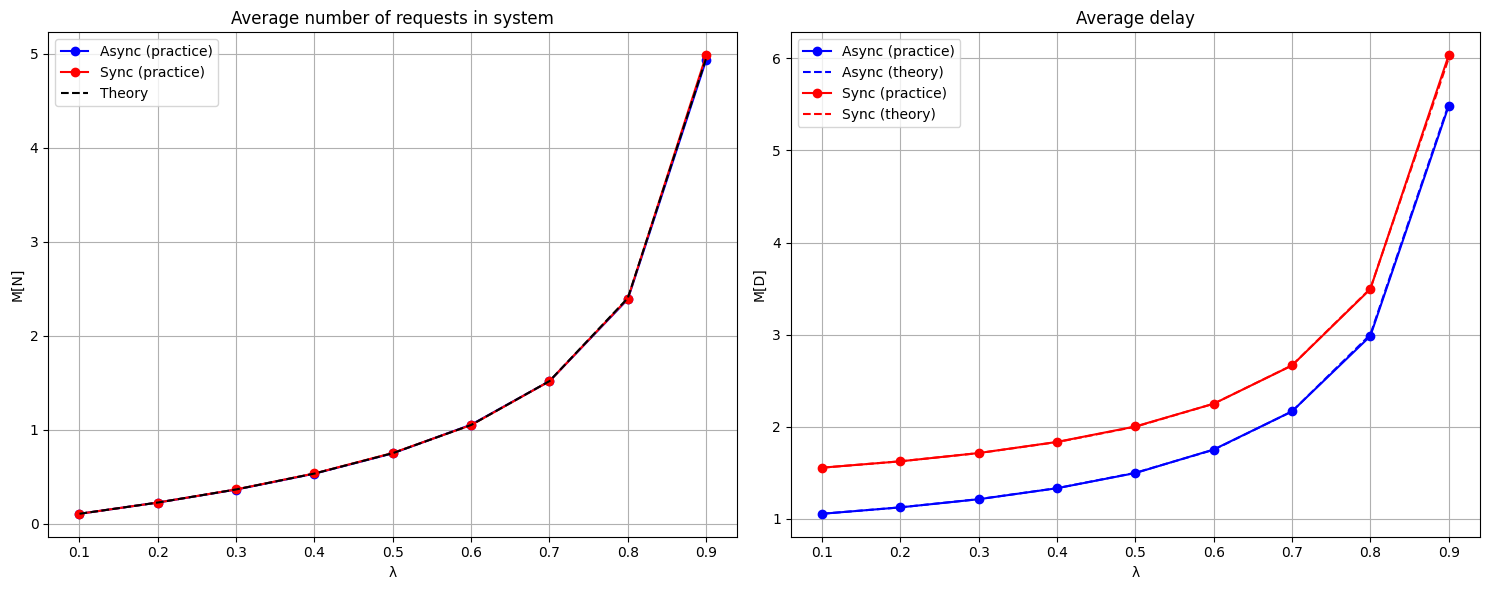

In [ ]:
lambda_params = np.linspace(0.1, 0.9, 9)
results = compare_systems(lambda_params, 1_000_000)
plot_results(lambda_params, results)

## Dop - LIFO


Simulation Results (LIFO Queue):
λ	| M[N] theor	| M[N] async	| M[N] sync	| M[D] async theor	| M[D] async pract	| M[D] sync theor	| M[D] sync pract
------------------------------------------------------------------------------------------------------------------------
0.1	| 0.106	| 0.105	| 0.106	| 1.056	| 1.052	| 1.556	| 1.556
0.2	| 0.225	| 0.219	| 0.224	| 1.125	| 1.118	| 1.625	| 1.627
0.3	| 0.364	| 0.370	| 0.374	| 1.214	| 1.225	| 1.714	| 1.724
0.4	| 0.533	| 0.531	| 0.533	| 1.333	| 1.332	| 1.833	| 1.838
0.5	| 0.750	| 0.728	| 0.750	| 1.500	| 1.478	| 2.000	| 2.005
0.6	| 1.050	| 1.040	| 1.074	| 1.750	| 1.758	| 2.250	| 2.267
0.7	| 1.517	| 1.579	| 1.584	| 2.167	| 2.225	| 2.667	| 2.734
0.8	| 2.400	| 2.407	| 2.535	| 3.000	| 3.040	| 3.500	| 3.682
0.9	| 4.950	| 4.758	| 5.163	| 5.500	| 5.268	| 6.000	| 6.184


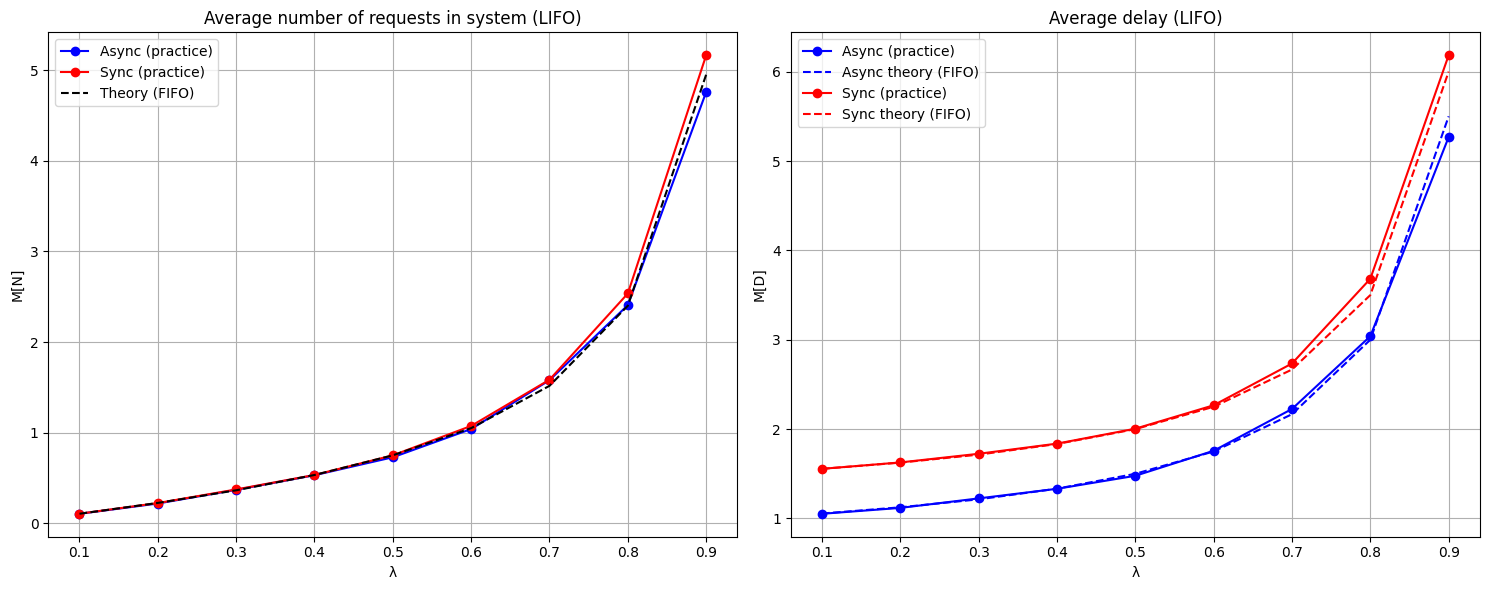

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from dataclasses import dataclass
from typing import List, Tuple

@dataclass
class Request:
    arrival_time: float
    service_start_time: float = None
    service_end_time: float = None

class QueueingSystem:
    def __init__(self, lambda_param: float, is_synchronous: bool = True):
        self.lambda_param = lambda_param
        self.mu = 1.0
        self.is_synchronous = is_synchronous
        self.current_time = 0
        self.queue = []  # Changed to list for LIFO operations
        self.completed_requests: List[Request] = []
        
    def generate_arrival_times(self, size: int) -> List[float]:
        tau = np.random.exponential(1/self.lambda_param, size)
        return np.cumsum(tau)
        
    def calculate_average_messages(self, timeline: List[float]) -> float:
        M_N = 0
        cur_mes = 0
        number_windows = int(np.ceil(timeline[-1]))
        
        queue = []  # Changed to list for LIFO operations
        for i in range(number_windows):
            if queue:
                queue.pop()  # LIFO: remove from the end instead of beginning
            while cur_mes < len(timeline) and timeline[cur_mes] < i:
                queue.append(cur_mes)
                cur_mes += 1
            M_N += len(queue)
            
        return M_N / number_windows if number_windows > 0 else 0

    def simulate(self, size: int = 100000):
        timeline = self.generate_arrival_times(size)
        times_send = [0.0]  # Start with initial time
        total_delay = 0
        
        t = np.ceil(timeline[0]) + 1
        total_delay += (t - timeline[0])
        times_send.append(t)
        
        for i in range(1, len(timeline)):
            if self.is_synchronous:
                t = np.ceil(timeline[i])
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    while t < times_send[-1] + 1:
                        t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
            else:  # Asynchronous
                t = timeline[i]
                if t >= times_send[-1]:
                    t += 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
                else:
                    t = times_send[-1] + 1
                    total_delay += (t - timeline[i])
                    times_send.append(t)
        
        avg_delay = total_delay / size
        avg_messages = self.calculate_average_messages(timeline)
        
        return avg_delay, avg_messages

def theoretical_values(lambda_param: float) -> Tuple[float, float, float]:
    # Note: These theoretical values are for FIFO queue
    # LIFO theoretical values might differ
    N = (lambda_param * (2 - lambda_param)) / (2 * (1 - lambda_param))
    
    D_async = (2 - lambda_param) / (2 * (1 - lambda_param))
    D_sync = D_async + 0.5
    
    return N, D_async, D_sync

def compare_systems(lambda_params: List[float], size: int):
    results = {
        'async': {'D': [], 'N': []},
        'sync': {'D': [], 'N': []},
        'theory': {'N': [], 'D_async': [], 'D_sync': []}
    }
    
    print("\nSimulation Results (LIFO Queue):")
    print("λ\t| M[N] theor\t| M[N] async\t| M[N] sync\t| M[D] async theor\t| M[D] async pract\t| M[D] sync theor\t| M[D] sync pract")
    print("-" * 120)
    
    for lambda_param in lambda_params:
        async_system = QueueingSystem(lambda_param, is_synchronous=False)
        D_async, N_async = async_system.simulate(size)
        
        sync_system = QueueingSystem(lambda_param, is_synchronous=True)
        D_sync, N_sync = sync_system.simulate(size)
        
        N_theory, D_async_theory, D_sync_theory = theoretical_values(lambda_param)
            
        results['async']['D'].append(D_async)
        results['async']['N'].append(N_async)
        results['sync']['D'].append(D_sync)
        results['sync']['N'].append(N_sync)
        results['theory']['N'].append(N_theory)
        results['theory']['D_async'].append(D_async_theory)
        results['theory']['D_sync'].append(D_sync_theory)
        
        print(f"{lambda_param:.1f}\t| {N_theory:.3f}\t| {N_async:.3f}\t| {N_sync:.3f}\t| {D_async_theory:.3f}\t| {D_async:.3f}\t| {D_sync_theory:.3f}\t| {D_sync:.3f}")
    
    return results

def plot_results(lambda_params: List[float], results: dict):
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(lambda_params, results['async']['N'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['sync']['N'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['N'], 'k--', label='Theory (FIFO)')
    plt.xlabel('λ')
    plt.ylabel('M[N]')
    plt.title('Average number of requests in system (LIFO)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(lambda_params, results['async']['D'], 'bo-', label='Async (practice)')
    plt.plot(lambda_params, results['theory']['D_async'], 'b--', label='Async theory (FIFO)')
    plt.plot(lambda_params, results['sync']['D'], 'ro-', label='Sync (practice)')
    plt.plot(lambda_params, results['theory']['D_sync'], 'r--', label='Sync theory (FIFO)')
    plt.xlabel('λ')
    plt.ylabel('M[D]')
    plt.title('Average delay (LIFO)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

lambda_params = np.linspace(0.1, 0.9, 9)
results = compare_systems(lambda_params, 10_000)
plot_results(lambda_params, results)

- Oдинаковое среднее количество сообщений (M[N]), поскольку оно зависит только от скорости поступления/обслуживания
- Одинаковая теоретическая средняя задержка (M[D]) в устойчивом состоянии

* FIFO: Каждый ждет своей очереди - предсказуемые задержки
* LIFO: Новые запросы переходят в очередь - одни получают быстрое обслуживание, другие ждут вечно
* Как прилавок в гастрономе и стопка бумаг: среднее время ожидания одинаковое, но бумаги в самом низу могут никогда не быть обработаны!

In [ ]:
import random
from dataclasses import dataclass
from typing import List, Optional, Dict
from collections import deque

@dataclass
class Message:
    id: int
    content: str
    is_error: bool = False
    
@dataclass
class Acknowledgment:
    message_id: int
    is_positive: bool

class Sender:
    def __init__(self, tau: int):
        self.tau = tau  # Задержка получения квитанции
        self.next_message_id = 1
        self.unacknowledged_messages: Dict[int, Message] = {}
        
    def send_message(self) -> Message:
        """Отправка нового сообщения"""
        message = Message(
            id=self.next_message_id,
            content=f"Message_{self.next_message_id}"
        )
        self.unacknowledged_messages[message.id] = message
        self.next_message_id += 1
        return message
    
    def resend_message(self, message_id: int) -> Optional[Message]:
        """Повторная отправка сообщения по его ID"""
        if message_id in self.unacknowledged_messages:
            return self.unacknowledged_messages[message_id]
        return None

class Receiver:
    def __init__(self, buffer_size: int):
        self.buffer_size = buffer_size
        self.buffer: Dict[int, Message] = {}  # Буфер для сообщений
        self.expected_message_id = 1  # ID следующего ожидаемого сообщения
        self.delivered_messages: List[Message] = []  # Доставленные сообщения
        
    def receive_message(self, message: Message) -> Acknowledgment:
        """Обработка входящего сообщения"""
        # Симулируем ошибку при передаче с вероятностью 0.2
        if random.random() < 0.2:
            message.is_error = True
            return Acknowledgment(message.id, is_positive=False)
            
        # Если сообщение пришло с ошибкой
        if message.is_error:
            return Acknowledgment(message.id, is_positive=False)
            
        # Если это ожидаемое сообщение
        if message.id == self.expected_message_id:
            self.delivered_messages.append(message)
            self.expected_message_id += 1
            
            # Проверяем буфер на наличие последовательных сообщений
            while self.expected_message_id in self.buffer:
                self.delivered_messages.append(self.buffer.pop(self.expected_message_id))
                self.expected_message_id += 1
                
            return Acknowledgment(message.id, is_positive=True)
            
        # Если это будущее сообщение и оно попадает в окно буфера
        if (message.id > self.expected_message_id and 
            message.id < self.expected_message_id + self.buffer_size):
            if len(self.buffer) < self.buffer_size:
                self.buffer[message.id] = message
                return Acknowledgment(message.id, is_positive=True)
                
        # Если буфер переполнен или сообщение вне окна
        return Acknowledgment(message.id, is_positive=False)

class SelectiveRepeatSimulation:
    def __init__(self, tau: int, buffer_size: int, simulation_time: int):
        self.tau = tau
        self.buffer_size = buffer_size
        self.simulation_time = simulation_time
        self.sender = Sender(tau)
        self.receiver = Receiver(buffer_size)
        self.acknowledgment_queue = deque()
        self.current_time = 0
        
    def run(self):
        """Запуск симуляции"""
        print(f"\nЗапуск симуляции с параметрами:")
        print(f"tau = {self.tau}")
        print(f"размер буфера = {self.buffer_size}")
        print(f"время симуляции = {self.simulation_time}\n")
        
        while self.current_time < self.simulation_time:
            print(f"\nВремя: {self.current_time}")
            
            # Отправка нового сообщения
            message = self.sender.send_message()
            print(f"Отправлено сообщение {message.id}")
            
            # Получение сообщения и отправка квитанции
            ack = self.receiver.receive_message(message)
            self.acknowledgment_queue.append((self.current_time + self.tau, ack))
            
            # Обработка пришедших квитанций
            while self.acknowledgment_queue and self.acknowledgment_queue[0][0] <= self.current_time:
                _, ack = self.acknowledgment_queue.popleft()
                if not ack.is_positive:
                    resent_message = self.sender.resend_message(ack.message_id)
                    if resent_message:
                        print(f"Повторная отправка сообщения {resent_message.id}")
                        new_ack = self.receiver.receive_message(resent_message)
                        self.acknowledgment_queue.append((self.current_time + self.tau, new_ack))
            
            # Вывод состояния системы
            print(f"Буфер приемника: {list(self.receiver.buffer.keys())}")
            print(f"Доставленные сообщения: {[msg.id for msg in self.receiver.delivered_messages]}")
            
            self.current_time += 1

simulation = SelectiveRepeatSimulation(
    tau=2,  # Задержка получения квитанции
    buffer_size=3,  # Размер буфера
    simulation_time=20  # Время симуляции
)
simulation.run()


Запуск симуляции с параметрами:
tau = 2
размер буфера = 3
время симуляции = 20


Время: 0
Отправлено сообщение 1
Буфер приемника: []
Доставленные сообщения: [1]

Время: 1
Отправлено сообщение 2
Буфер приемника: []
Доставленные сообщения: [1, 2]

Время: 2
Отправлено сообщение 3
Буфер приемника: []
Доставленные сообщения: [1, 2, 3]

Время: 3
Отправлено сообщение 4
Буфер приемника: []
Доставленные сообщения: [1, 2, 3, 4]

Время: 4
Отправлено сообщение 5
Буфер приемника: []
Доставленные сообщения: [1, 2, 3, 4, 5]

Время: 5
Отправлено сообщение 6
Буфер приемника: []
Доставленные сообщения: [1, 2, 3, 4, 5, 6]

Время: 6
Отправлено сообщение 7
Буфер приемника: []
Доставленные сообщения: [1, 2, 3, 4, 5, 6, 7]

Время: 7
Отправлено сообщение 8
Буфер приемника: []
Доставленные сообщения: [1, 2, 3, 4, 5, 6, 7]

Время: 8
Отправлено сообщение 9
Буфер приемника: [9]
Доставленные сообщения: [1, 2, 3, 4, 5, 6, 7]

Время: 9
Отправлено сообщение 10
Повторная отправка сообщения 8
Буфер приемника: [9, 10]
